In [1]:
from scipy.io import wavfile 
capstone_dir = "/Users/ninismacbook/other_docs/Y4S1+S2/capstone" 
import matplotlib.pyplot as plt; import numpy as np; import pandas as pd ; import librosa
import librosa.display # Must have
from dtw import dtw; import scipy.stats ; from scipy import stats ; import statsmodels.api as sm
import math

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Everything together - 13 MFCCs

In [2]:
def normalize(mfcc):
    
    matrix = np.zeros((mfcc.shape))
    
    for i in range(mfcc.shape[0]):
        array = mfcc[i, :]
        mean = np.mean(array)
        sd = np.std(array)
        
        for j in range(mfcc.shape[1]):
            new_val = (mfcc[i, j]-mean)/sd
            if new_val > 2:
                new_val == 2
            if new_val < -2:
                new_val == -2
            matrix[i, j] = new_val/5 + 0.5
    return matrix

# print(normalize(np.array([[-3, -2, -1], [3, 2, 3]])))

In [3]:
# deviation function
def deviation(rho, theta):
    dev = 0
    if rho >= theta and rho <= math.pi/2:
        dev = (rho-theta)/(math.pi/2-theta)
    else:
        dev = (theta - rho)/theta
    return dev

In [4]:
def speech(smooth_query, original_query, seg1_1, seg1_2, samplerate, frame_per_window, **kwargs):

    input_min_amp = kwargs.get('input_min_amp', None)
    input_min_pause = kwargs.get('input_min_pause', 50)    # unit = ms
    
    if input_min_amp == None:
        abs_q = np.abs(smooth_query[int(samplerate*0.5): int(samplerate*1.5)])    
        default_min_amp = np.max(abs_q)
        print('Default amplitude threshold: ', default_min_amp)
        min_amp = default_min_amp
    else:
        min_amp = input_min_amp
    
    indices = []
    max_am = max(np.abs(original_query))    
    result = []                
    result.append(0) # the first frame is always pause
    
    for i in range(1, len(smooth_query)):    

        # Since we scaled the amplitudes, we need to multiply the smoothened amplitude value by the normalization constant
        if np.abs(smooth_query[i]) > min_amp:
            
            if result[-1] == 0: # if previous frame is pause, this index marks start of speech
                indices.append(i)
            result.append(1)
            
        else:
            if result[-1] == 1: # if previous frame is speech, this index marks end of speech
                indices.append(i)
            result.append(0)
    
    min_pause_len = input_min_pause * samplerate /1000

    # filter out pauses whose length is shorter than input_min_pause
    for p in range(1, len(indices)-1, 2):
        if indices[p+1] - indices[p] < min_pause_len:

            # Update result: change the pauses that are too short to speech
            result[indices[p] : indices[p+1]] = [1] * (indices[p+1] - indices[p])
            
            # Update the indices to -1, and remove all -1 index in the end
            indices[p+1] = -1
            indices[p] = -1

    indices = [seg for seg in indices if seg != -1]            

    return result, min_amp

In [5]:
def calc_path_len(alignment):

    counter = 0
    for i in alignment.stepsTaken:
        if i == 1:
            counter = counter + 1
    return counter*math.sqrt(2)+len(alignment.stepsTaken)-counter

In [6]:
def plot_all_mfccs(mfcc1_normal, mfcc2_normal):
    time1 = np.linspace(0, mfcc1_normal.shape[1], num = mfcc1_normal.shape[1])   
    plt.figure(figsize=(10,3))
    for i in mfcc1_normal:
        plt.plot(time1, i);   
    
    time1 = np.linspace(0, mfcc2_normal.shape[1], num = mfcc2_normal.shape[1])
    plt.figure(figsize=(10,3))
    for i in mfcc2_normal:
        plt.plot(time1, i);   

In [7]:
def create_smooth_x(fragment_x, frame_per_window):
    smooth_x = [] # Store smoothened sample array    
    for i in range(len(fragment_x)):
        if i < frame_per_window/2:
            i1 = 0 ; i2 = i + int(frame_per_window/2)            
        elif i > (len(fragment_x) - frame_per_window/2):
            i1 = i - frame_per_window/2 ; i2 = len(fragment_x)
        else:
            i1 = i-frame_per_window/2 ; i2 = i+frame_per_window/2
        num = np.mean(np.abs(fragment_x[int(i1) : int(i2)]))
        smooth_x.append(num) 
    return smooth_x

In [8]:
def plot_seg_and_alignment(timelst1, timelst2, alignment, seg1_1, seg1_2, sr1, seg2_1, seg2_2, sr2, hop_len_in_s):
    if timelst1 and timelst2:              # plot where the segments are on the bigger alignment curve plot
        plt.figure(figsize=(15, 3))
        plt.plot(alignment.index1, alignment.index2)
        
        time1_2 = (np.array(timelst1) - seg1_1)*sr1/int(hop_len_in_s*sr1)
        time2_2 = (np.array(timelst2) - seg2_1)*sr2/int(hop_len_in_s*sr2)

        colors = ['red', 'g', 'b', 'm', 'brown', '#d89743', 'grey', 'c', 'orange', 'g', 'b', 'm', 'red']

        for i in range(len(time1_2)):
            x_axis, y_axis = time1_2[i], time2_2[i]
            plt.axvline(x_axis, color = colors[i])
            plt.hlines(y_axis, 0, x_axis+10, color = colors[i]) 

In [9]:
def stretch(alignment, seg_index_x, seg_index_y, common_seg_dict, path_indices, csv_matrix, fps_ratio):
    
    theta = math.atan(fps_ratio)
    overall_stretch = 0
    overall_arclen = 0
    
    for s in range(0, len(path_indices)-1):     # calculate stretch in each common segment

        xs = alignment.index1[path_indices[s]:path_indices[s+1]]
        ys = alignment.index2[path_indices[s]:path_indices[s+1]]

        stretch = 0
        arclen = 0            

        for i in range(0, len(xs)-1):
            
            if xs[i+1]-xs[i] == 0:
                rho_i = math.pi/2
            else:
                rho_i = math.atan((ys[i+1]-ys[i]) / (xs[i+1]-xs[i]))

            dev_rho_i = deviation(rho_i, theta)
            stretch = stretch + dev_rho_i*math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)

            overall_stretch = overall_stretch + stretch
                
            arclen = arclen + math.sqrt((xs[i+1]-xs[i])**2 + (ys[i+1]-ys[i])**2)
            overall_arclen = overall_arclen + arclen            
        
        if arclen == 0:
            segment_stretch = 0
        else:
            segment_stretch = stretch/arclen
        
        common_seg_dict[s+1].append('%3.2f' %segment_stretch) # the index is s+1 because common_seg_dict starts with 1
        csv_matrix[s+1].append('%3.2f' %segment_stretch) # the index is s+1 because common_seg_dict starts with 1
        
    return overall_arclen, overall_stretch

In [10]:
def plot_alignment_curve_marked_with_segments(xs, ys, path_indices):   # plot the alignment curve marked with segments
    plot_ratio = max(xs) // 10
    plt.figure(figsize=(max(xs)/plot_ratio, max(ys)/plot_ratio)) 
    plt.plot(xs, ys, linewidth=1)
    plt.plot([0, max(xs)], [0, max(ys)])
    
    for k in range(len(path_indices)):
        x_axis = xs[path_indices[k]]
        y_axis = ys[path_indices[k]]
        plt.scatter(x_axis, y_axis, color = 'black')

In [11]:
def calc_seg_len(common_seg_dict):
    for i in common_seg_dict:
        if i != len(common_seg_dict):
            common_seg_dict[i].append('%3.2f' %(float(common_seg_dict[i+1][1])-float(common_seg_dict[i][1])))
            common_seg_dict[i].append('%3.2f' %(float(common_seg_dict[i+1][2])-float(common_seg_dict[i][2])))

In [12]:
def print_stretch_and_distance(alignment, num_of_mfcc, overall_stretch, overall_arclen):
    print('Stretch = %3.2f' % (overall_stretch/overall_arclen))
    print('Distance  = %3.2f' % (alignment.distance/math.sqrt(num_of_mfcc)/calc_path_len(alignment)))

In [13]:
def plot_amplitude_subplots(fragment_x, fragment_y, seg1_1, seg1_2, speech_x, smooth_x, seg2_1, seg2_2, min_amp_x, timelst1, timelst2, common_seg_dict):
    fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5, 1)
    fig.set_size_inches(20, 8)

    time = np.linspace(seg1_1, seg1_2, num = len(fragment_x))
    xticks = np.linspace(seg1_1, seg1_2, num = 20)
    
    ax1.plot(time, fragment_x)
    ax1.set_xticks(xticks) 
    if timelst1:
        for t in timelst1:
                ax1.axvline(t, color = 'black', ymin=0, ymax=1, linewidth=2)        
    
    ax2.plot(time, smooth_x)
    ax2.set_xticks(xticks)
    ax2.axhline(y = min_amp_x)          
    ax3.plot(time, speech_x)
    ax3.set_xticks(xticks)

    time = np.linspace(seg2_1, seg2_2, num = len(fragment_y))
    xticks = np.linspace(seg2_1, seg2_2, num = 20)
    
    ax4.plot(time, fragment_y)
    if timelst2:
            for t in timelst2:
                    ax4.axvline(t, color = 'black', ymin=0, ymax=1, linewidth=2)       
    ax4.set_xticks(xticks) 
    

    ax5.plot(time, fragment_y)
    ax5.set_xticks(xticks)      

    color_counter = 0
    for seg in list(common_seg_dict.values()):

        if color_counter % 2 == 0:
            c = 'red'
        else:
            c = 'green'

        ax3.axvline(seg[1], color = c, ymin=0, ymax=1, linewidth=4)   
        ax5.axvline(seg[2], color = c, ymin=0, ymax=1, linewidth=4)    
                        
        color_counter = color_counter + 1

In [14]:
def remove_short_seg(speech_array, min_pause_len_s, min_speech_len_s, sr1, sr2): # filter out pauses shorter than min_pause_len_s in speech array
    
    sp_transitions = []     
    for s in range(len(speech_array)-1):
        if s > 0 and s < len(speech_array):
            if speech_array[s] == 0 and speech_array[s+1] == 1:
                sp_transitions.append(s)
            if speech_array[s] == 1 and speech_array[s+1] == 0:
                sp_transitions.append(s)
    
    for t in range(1, len(sp_transitions)-1, 2):
        if (sp_transitions[t+1] - sp_transitions[t])/sr1 < min_pause_len_s:
            speech_array[sp_transitions[t]:sp_transitions[t+2]] = [1]*(sp_transitions[t+2]-sp_transitions[t])
            

    for t in range(0, len(sp_transitions)-1, 2):
        if (sp_transitions[t+1] - sp_transitions[t])/sr2 < min_speech_len_s:
            speech_array[sp_transitions[t]:sp_transitions[t+2]] = [0]*(sp_transitions[t+2]-sp_transitions[t])            
    
    sp_transitions = []     
    for s in range(len(speech_array)-1):
        if s > 0 and s < len(speech_array):
            if speech_array[s] == 0 and speech_array[s+1] == 1:
                sp_transitions.append(s)
            if speech_array[s] == 1 and speech_array[s+1] == 0:
                sp_transitions.append(s)
                
    return speech_array

# words

In [15]:
window_len = 50
hop_len_in_s = 0.01 # set hop_length = __ s. Number of mfcc frames = audio length * samplerate / hop length (default = 512)
# mfcc_len_s_1

segments1 = ['We have', 'pause', 'really en', 'pause', 'joyed','pause', 'the','pause', 'project', 'pause', '','','','','','','']
segments2 = ['We have', 'pause', 'really en', 'pause', 'joyed','pause', 'the','pause', 'project', 'pause', '','','','','','','']

segmentsnormal2 = ['We have', 'pause', 'really en', 'pause', 'joyed','pause', 'the','pause', 'projec', 'pause', 't','','','','','','']
segmentsnormal3 = ['We', 'pause', 'have', 'pause', 'really en', 'pause', 'joyed','pause', 'the','pause', 'pro', 'pause', 'ject','','','','','','', '', '', '', '', '', '']
segmentspause1 = ['We have', 'pause', 'really', 'pause', 'enjoyed', 'pause', 'the','pause', 'pro','pause', 'ject', 'pause', 'ject','','','','','','']
segmentspause2 = ['We have', 'pause', 'really en', 'pause','joyed','pause' ,'the','pause', 'pro','pause', 'ject', 'pause', 'ject','','','','','','']
segmentslongword2 = ['We', 'pause', 'have', 'pause', 'rea','pause','lly', 'pause', 'en', 'pause','joyed','pause','the','pause', 'pro','pause', 'ject', 'pause', 'ject','','','','','','']

In [16]:
def return_common_seg(alignment, sr1, speech_x, time1, time2, min_pause_len_s, mfcc_len_s_1, segments):
    
    xs = alignment.index1
    ys = alignment.index2

    common_seg = {} # store the list of speech and pause segments
    common_seg_dict = {}
    csv_matrix = {}
    path_indices = []

    seg_index_x = []
    seg_index_y = []
    
    len_x = len(speech_x)
    
    seg_index = 0

    counter = 0    
    for i in range(len(speech_x)-1):  # get segments in y based on alignment curve

        if speech_x[i] != speech_x[i+1]:
            
            seg = segments[counter]
            counter = counter + 1
            
            seg_index_x = int(i/len_x*max(alignment.index1))       #i/len_x = the proportion in speech_x, and max(alignment.index1) gives the total number of mfcc in x
            timestamps_x = seg_index_x*mfcc_len_s_1+time1[0]

            y_index = np.where(alignment.index1 == seg_index_x)    
            seg_index_y = alignment.index2[y_index][0]
        
            timestamps_y = seg_index_y*mfcc_len_s_1+time2[0]
            common_seg_dict[seg_index+1] = [seg, timestamps_x, timestamps_y]
            csv_matrix[seg_index+1] = [seg]
            
            
            seg_index = seg_index + 1  
            path_indices.append(y_index[0][0])
    
    path_indices = np.squeeze(path_indices)
    
    return seg_index_x, seg_index_y, common_seg_dict, path_indices, csv_matrix

In [17]:
def output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, *args, **kwargs):
    
    threshold1 = kwargs.get('threshold1', None)
    timelst1 = kwargs.get('timelst1', None)
    timelst2 = kwargs.get('timelst2', None)
    segments = kwargs.get('segments', segments1)
    num_of_mfcc = kwargs.get('num_of_mfcc', 13)
    input_min_pause = kwargs.get('input_min_pause', 50)
    input_min_speech = kwargs.get('input_min_speech', 50)    
    min_pause_len_s = input_min_pause /1000   
    min_speech_len_s = input_min_speech /1000   

    x, sr1 = librosa.load(capstone_dir + "/py_converted/" + file1, sr=None)
    y, sr2 = librosa.load(capstone_dir + "/py_converted/" + file2, sr=None)
    frame_per_window = sr1 * window_len/1000 # Smoothen amplitude values in x
    
    fragment_x = x[int(sr1*seg1_1): int(sr1*seg1_2)]
    fragment_y = y[int(sr2*seg2_1): int(sr2*seg2_2)]

    mfcc1 = librosa.feature.mfcc(fragment_x, sr1, n_mfcc=num_of_mfcc, hop_length=int(hop_len_in_s*sr1))
    mfcc2 = librosa.feature.mfcc(fragment_y, sr2, n_mfcc=num_of_mfcc, hop_length=int(hop_len_in_s*sr2)) 

    time1 = np.linspace(seg1_1, seg1_2, num = mfcc1.shape[1])     
    time2 = np.linspace(seg2_1, seg2_2, num = mfcc2.shape[1])    
    
    mfcc_len_s_1 = (time1[-1]-time1[0])/mfcc1.shape[1] # duration of each mfcc = audio length / number of mfcc 
    mfcc_len_s_2 = (time2[-1]-time2[0])/mfcc2.shape[1] # duration of each mfcc = audio length / number of mfcc     
    
    mfcc1_normal = normalize(mfcc1) # normalize each mfcc
    mfcc2_normal = normalize(mfcc2)
#     plot_all_mfccs(mfcc1_normal, mfcc2_normal); # plot all MFCCS    
    
    alignment = dtw(mfcc1_normal.T, mfcc2_normal.T, step_pattern = 'symmetric1', dist_method = 'euclidean', keep_internals=True)
    alignment.plot('threeway')
#     plot_seg_and_alignment(timelst1, timelst2, alignment, seg1_1, seg1_2, sr1, seg2_1, seg2_2, sr2, hop_len_in_s)   
    
    smooth_x = create_smooth_x(fragment_x, frame_per_window)       
    speech_x, min_amp_x = speech(smooth_x, x, seg1_1, seg1_2, sr1, frame_per_window, input_min_amp = threshold1, input_min_pause = input_min_pause)  
    speech_x = remove_short_seg(speech_x, min_pause_len_s, min_speech_len_s, sr1, sr2)
    
    xs = alignment.index1
    ys = alignment.index2 
    
    seg_index_x, seg_index_y, common_seg_dict, path_indices, csv_matrix = return_common_seg(alignment, sr1, speech_x, time1, time2, min_pause_len_s, mfcc_len_s_1, segments)
    
    # plot speech_x, smooth_x, and segmentation results on y    
    plot_amplitude_subplots(fragment_x, fragment_y, seg1_1, seg1_2, speech_x, smooth_x, seg2_1, seg2_2, min_amp_x, timelst1, timelst2, common_seg_dict)

    calc_seg_mfcc(alignment, path_indices, common_seg_dict, csv_matrix, mfcc1_normal, mfcc2_normal)

    calc_seg_len(common_seg_dict)
    common_seg_dict.pop(len(common_seg_dict)) # remove the last pause segment
    csv_matrix.pop(len(csv_matrix)) # remove the last pause segment
   
    overall_arclen, overall_stretch = stretch(alignment, seg_index_x, seg_index_y, common_seg_dict, path_indices, csv_matrix, mfcc_len_s_1/mfcc_len_s_2)    
    # mfcc_len_s_1/mfcc_len_s_2 equals to mfcc2/s over mfcc1/s
    
    print_stretch_and_distance(alignment, num_of_mfcc, overall_stretch, overall_arclen)  
    avg_corr = plot_each_mfcc(num_of_mfcc, mfcc1_normal, mfcc2_normal, alignment, path_indices)  # check mfcc alignment results, plot each aligned mfcc    
    
    csv_matrix[len(csv_matrix)+1] = 'all', avg_corr, '%3.2f' %(overall_stretch/overall_arclen)
    
    print_output_matrix(common_seg_dict, csv_matrix, file1, file2)
    
#     plot_alignment_curve_marked_with_segments(xs, ys, path_indices)   # plot the alignment curve marked with segments

In [18]:
def print_output_matrix(common_seg_dict, csv_matrix, file1, file2):
    df1 = pd.DataFrame(common_seg_dict)
    df1.index = ['seg', 'start 1', 'start 2',  'Adj R^2', 'len 1', 'len 2','stretch']
#     pd.options.display.float_format = "{:,.2f}".format
    display(df1)
    df = pd.DataFrame(csv_matrix)    

    df.index = ['seg',  'corr', 'stretch']
    display(df)
    filename = '/Users/ninismacbook/desktop/' + file1.replace('.wav','').replace('report-', '') + file2.replace('.wav','').replace('report-', '') + '.csv' 
    df.to_csv(filename)

In [20]:
# calculate average adjusted R squared of MFCC in each segment

def calc_seg_mfcc(alignment, path_indices, common_seg_dict, csv_matrix, mfcc1_normal, mfcc2_normal):
    
    for seg_index in range(len(path_indices)-1):
        avg_corr = []
        
        start = path_indices[seg_index]
        end = path_indices[seg_index+1]
        
        xs = mfcc1_normal.T[alignment.index1[start: end]]
        ys = mfcc2_normal.T[alignment.index2[start: end]]
        
        for mfcc_index in range(13):
            x = xs[:, mfcc_index]
            y = ys[:, mfcc_index]
            
            res = stats.linregress(x, y)  
            X = sm.add_constant(x)
            model = sm.OLS(y, X).fit()
            avg_corr.append(model.rsquared_adj)
            
#             plt.subplots(1, 1) 
#             plt.scatter(x, y, color = 'black')            
        
        corr = np.average(avg_corr)
        common_seg_dict[seg_index+1].append('%3.2f' %corr)
        csv_matrix[seg_index+1].append('%3.2f' %corr)

In [91]:
def plot_each_mfcc(num_of_mfcc, mfcc1_normal, mfcc2_normal, alignment, path_indices):
    
    avg_corr = []
        
    print(path_indices)
    xs = mfcc1_normal.T[alignment.index1[path_indices[0]: path_indices[-1]], :]
    ys = mfcc2_normal.T[alignment.index2[path_indices[0]: path_indices[-1]], :]    
    print(xs.shape, ys.shape)
    
    for k in range(num_of_mfcc):      
                    
        plot_x = xs[:, k]
        plot_y = ys[:, k]
        
        res = stats.linregress(plot_x, plot_y)      
        X = sm.add_constant(plot_x)
        model = sm.OLS(plot_y, X).fit()
        avg_corr.append(model.rsquared_adj)
    
#         plt.subplots(1, 1) 
#         plt.scatter(plot_x, plot_y, color = 'black')    
#         plt.title(label= 'MFCC ' + str(k+1) + '. Adjusted R squared = %3.2f'  % model.rsquared_adj)
#         avg_corr.append(scipy.stats.pearsonr(plot_x, plot_y)[0])
    
    print('Correlation = %3.2f' %np.average(avg_corr))
    
    return '%3.2f' %np.average(avg_corr)

# 1. normal1normal2  isinreport

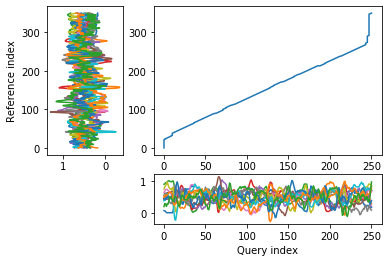

Stretch = 0.07
Distance  = 0.10
[ 40  76  92 156 163 195 210 216 231 266]
(226, 13) (226, 13)
Correlation = 0.69


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.61952  1.96813    2.12749  2.73506  2.79482  3.09363  3.24303   
start 2  1.89841  2.25697    2.39641  3.01394  3.08367  3.38247  3.52191   
Adj R^2     0.73     0.36       0.63     0.53     0.64     0.19     0.28   
len 1       0.35     0.16       0.61     0.06     0.30     0.15     0.06   
len 2       0.36     0.14       0.62     0.07     0.30     0.14     0.06   
stretch     0.02     0.05       0.06     0.12     0.10     0.05     0.00   

               8        9  
seg        pause  project  
start 1  3.30279  3.44223  
start 2  3.58167   3.7012  
Adj R^2     0.31     0.67  
len 1       0.14     0.35  
len 2       0.12     0.34  
stretch     0.22     0.02

1      2          3      4      5      6     7      8        9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  project   
corr        0.73   0.36       0.63   0.53   0.64   0.19  0.28   0.31     0.67   
stretch     0.02   0.05       0.06   0.12   0.10   0.05  0.00   0.22     0.02   

           10  
seg       all  
corr     0.69  
stretch  0.07

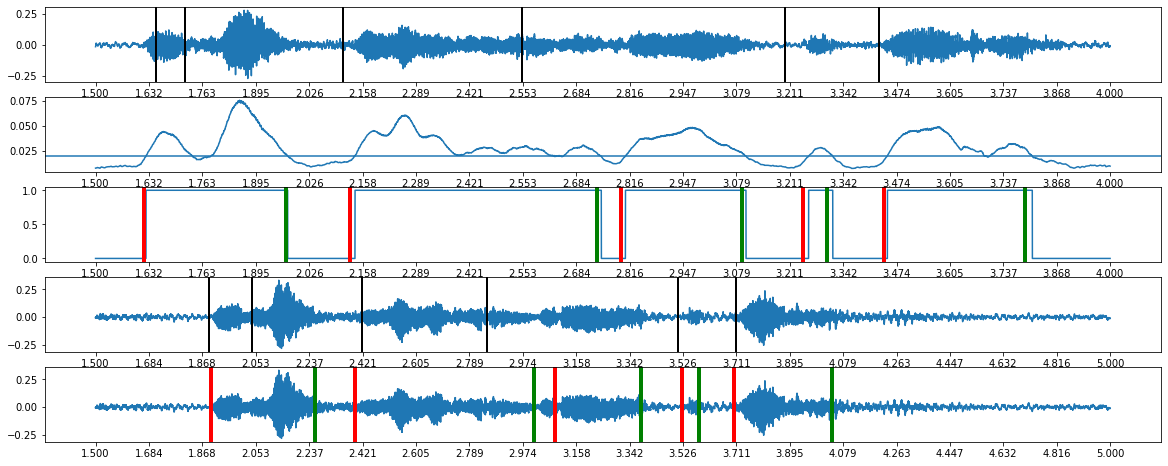

In [92]:
window_len = 50

file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-normal2.wav", 1.5, 5

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]
timelst2 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, 
       threshold1=0.02, 
      timelst1=timelst1, timelst2 = timelst2) # unit for input_min_pause = ms

# 2. normal1pause1

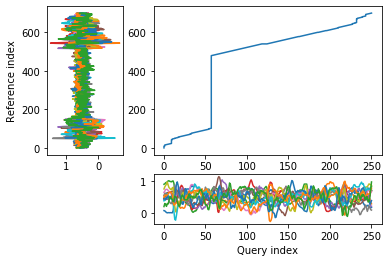

Stretch = 0.87
Distance  = 0.15
Correlation = 0.32


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.61952  1.96813    2.12749  2.73506  2.79482  3.09363  3.24303   
start 2  1.97809  2.39641    6.33068  6.87849  6.93825  7.23705  7.37649   
Adj R^2     0.68     0.05       0.13     0.55     0.79     0.21     0.37   
len 1       0.35     0.16       0.61     0.06     0.30     0.15     0.06   
len 2       0.42     3.93       0.55     0.06     0.30     0.14     0.06   
stretch     0.13     0.95       0.06     0.00     0.00     0.05     0.00   

               8        9  
seg        pause  project  
start 1  3.30279  3.44223  
start 2  7.43625  7.56574  
Adj R^2     0.37     0.63  
len 1       0.14     0.35  
len 2       0.13     0.39  
stretch     0.06     0.12

1      2          3      4      5      6     7      8        9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  project   
corr        0.68   0.05       0.13   0.55   0.79   0.21  0.37   0.37     0.63   
stretch     0.13   0.95       0.06   0.00   0.00   0.05  0.00   0.06     0.12   

           10  
seg       all  
corr     0.32  
stretch  0.87

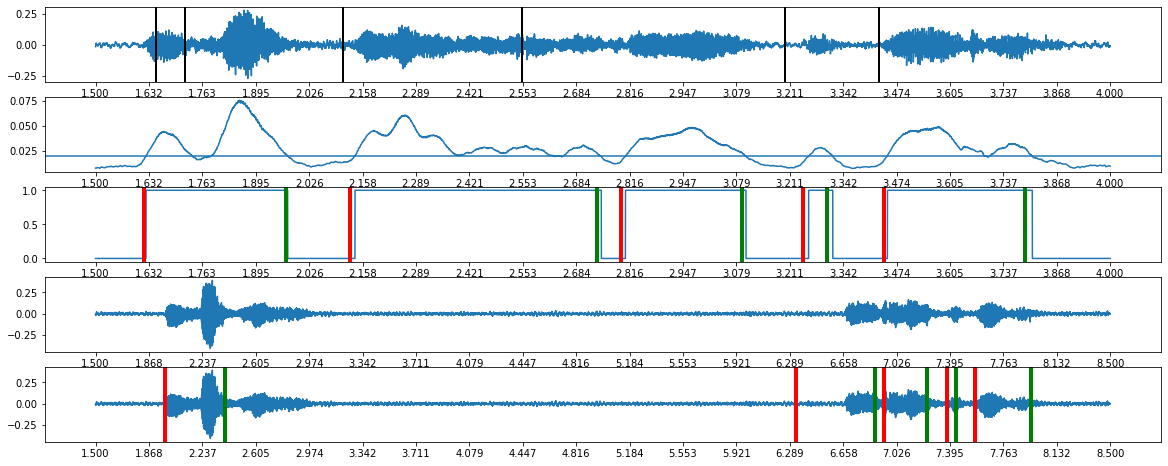

In [22]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-pause1.wav", 1.5, 8.5

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, 
       threshold1 = 0.02, timelst1=timelst1)

# 3. normal1pause2  isinreport

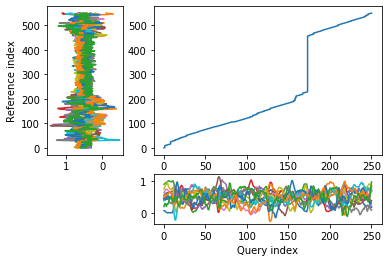

Stretch = 0.72
Distance  = 0.12
Correlation = 0.63


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.61952  1.96813    2.12749  2.73506  2.79482  3.09363  3.24303   
start 2  1.28884  1.71713    1.86653  2.53386  2.62351  3.11155  5.56175   
Adj R^2     0.62     0.43       0.57     0.40     0.60     0.08     0.43   
len 1       0.35     0.16       0.61     0.06     0.30     0.15     0.06   
len 2       0.43     0.15       0.67     0.09     0.49     2.45     0.10   
stretch     0.14     0.00       0.13     0.30     0.32     0.92     0.36   

               8        9  
seg        pause  project  
start 1  3.30279  3.44223  
start 2  5.66135  5.82072  
Adj R^2     0.25     0.57  
len 1       0.14     0.35  
len 2       0.16     0.39  
stretch     0.10     0.08

1      2          3      4      5      6     7      8        9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  project   
corr        0.62   0.43       0.57   0.40   0.60   0.08  0.43   0.25     0.57   
stretch     0.14   0.00       0.13   0.30   0.32   0.92  0.36   0.10     0.08   

           10  
seg       all  
corr     0.63  
stretch  0.72

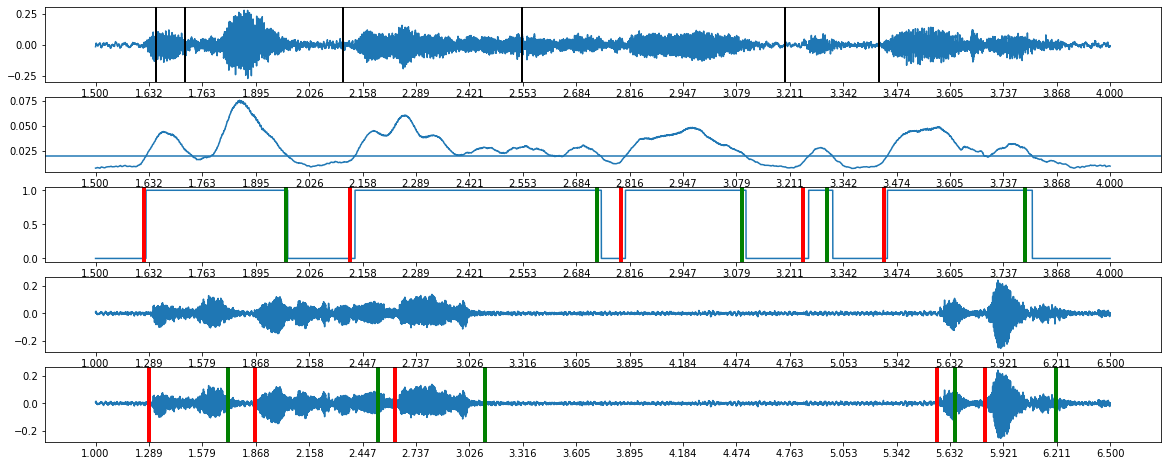

In [23]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-pause2.wav", 1, 6.5

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, 
       threshold1 = 0.02, timelst1=timelst1)

# 4. normal1longword1    isinreport

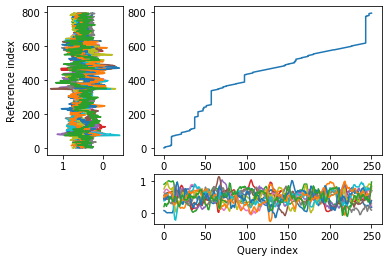

Stretch = 0.60
Distance  = 0.13
Correlation = 0.51


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.61952  1.96813    2.12749  2.73506  2.79482  3.09363  3.24303   
start 2  1.70717  3.17131    4.40637  5.59163  5.65139   6.1992  6.41833   
Adj R^2     0.46     0.32       0.28     0.49     0.54     0.24     0.42   
len 1       0.35     0.16       0.61     0.06     0.30     0.15     0.06   
len 2       1.46     1.24       1.19     0.06     0.55     0.22     0.09   
stretch     0.72     0.85       0.45     0.08     0.43     0.32     0.35   

               8        9  
seg        pause  project  
start 1  3.30279  3.44223  
start 2  6.50797  6.64741  
Adj R^2     0.34     0.57  
len 1       0.14     0.35  
len 2       0.14     0.36  
stretch     0.08     0.13

1      2          3      4      5      6     7      8        9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  project   
corr        0.46   0.32       0.28   0.49   0.54   0.24  0.42   0.34     0.57   
stretch     0.72   0.85       0.45   0.08   0.43   0.32  0.35   0.08     0.13   

           10  
seg       all  
corr     0.51  
stretch  0.60

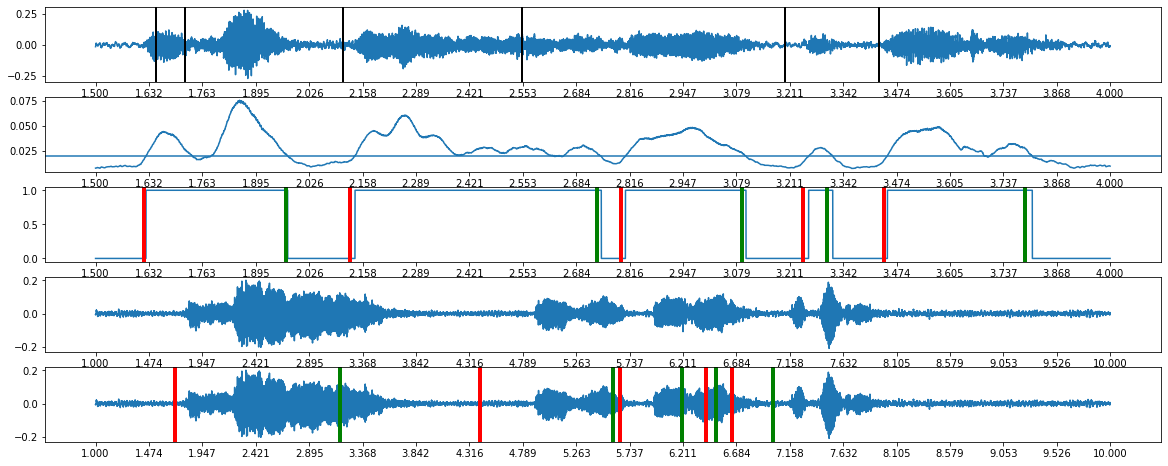

In [24]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-longword1.wav", 1, 10

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, 
       threshold1 = 0.02, timelst1=timelst1)

# 5. normal1longword2

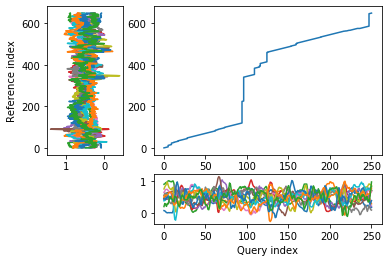

Stretch = 0.70
Distance  = 0.13
Correlation = 0.46


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.61952  1.96813    2.12749  2.73506  2.79482  3.09363  3.24303   
start 2  1.75896  2.16733    2.35657  5.63347  6.15139  6.50996  6.67928   
Adj R^2     0.62     0.24       0.18     0.20     0.63     0.22     0.45   
len 1       0.35     0.16       0.61     0.06     0.30     0.15     0.06   
len 2       0.41     0.19       3.28     0.52     0.36     0.17     0.06   
stretch     0.11     0.13       0.76     0.87     0.13     0.09     0.00   

               8        9  
seg        pause  project  
start 1  3.30279  3.44223  
start 2  6.73904  6.88845  
Adj R^2     0.25     0.51  
len 1       0.14     0.35  
len 2       0.15     0.32  
stretch     0.05     0.07

1      2          3      4      5      6     7      8        9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  project   
corr        0.62   0.24       0.18   0.20   0.63   0.22  0.45   0.25     0.51   
stretch     0.11   0.13       0.76   0.87   0.13   0.09  0.00   0.05     0.07   

           10  
seg       all  
corr     0.46  
stretch  0.70

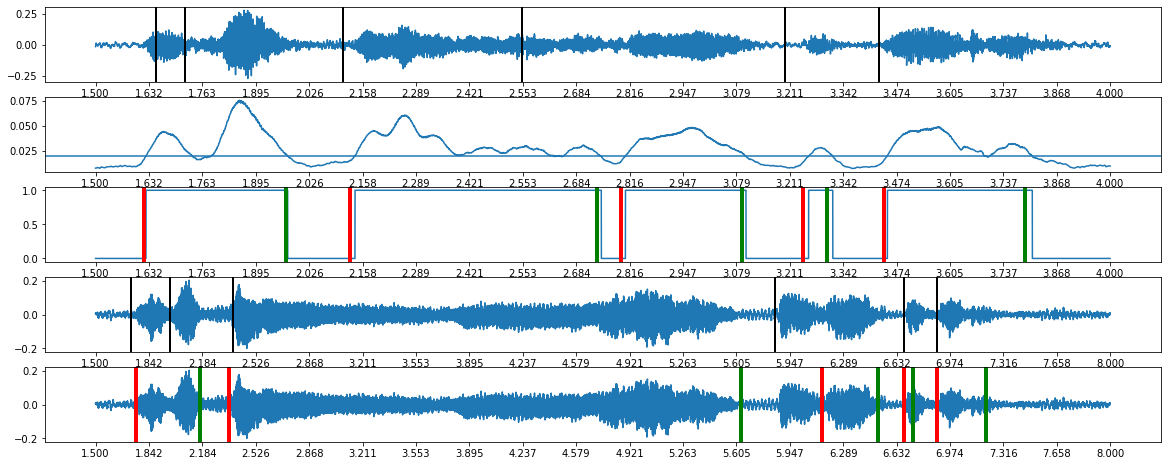

In [25]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-longword2.wav", 1.5, 8

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]
timelst2 = [1.73, 1.98, 2.38, 5.85, 6.68, 6.89]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, 
       threshold1 = 0.02, timelst1=timelst1, timelst2 = timelst2)

# 6. normal1combo1  isinreport

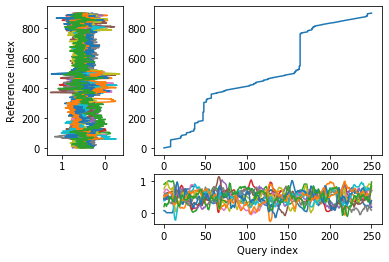

Stretch = 0.82
Distance  = 0.14
Correlation = 0.50


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.61952  1.96813    2.12749  2.73506  2.79482  3.09363  3.24303   
start 2  1.56773  2.81275    4.63546  5.54183  5.65139  6.16932  8.80876   
Adj R^2     0.47     0.37       0.44     0.45     0.56     0.05     0.44   
len 1       0.35     0.16       0.61     0.06     0.30     0.15     0.06   
len 2       1.25     1.82       0.91     0.11     0.52     2.64     0.24   
stretch     0.65     0.89       0.26     0.42     0.35     0.93     0.72   

               8        9  
seg        pause  project  
start 1  3.30279  3.44223  
start 2  9.04781  9.24701  
Adj R^2     0.38     0.57  
len 1       0.14     0.35  
len 2       0.20     0.35  
stretch     0.25     0.04

1      2          3      4      5      6     7      8        9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  project   
corr        0.47   0.37       0.44   0.45   0.56   0.05  0.44   0.38     0.57   
stretch     0.65   0.89       0.26   0.42   0.35   0.93  0.72   0.25     0.04   

           10  
seg       all  
corr     0.50  
stretch  0.82

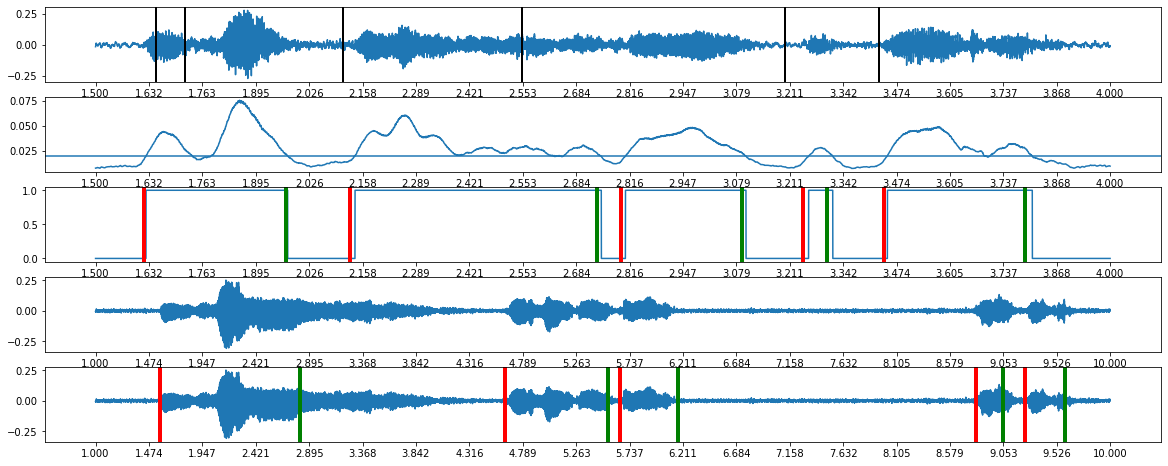

In [26]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-combo1.wav", 1, 10

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, 
       threshold1 = 0.02, timelst1=timelst1)

# 7. normal1combo2

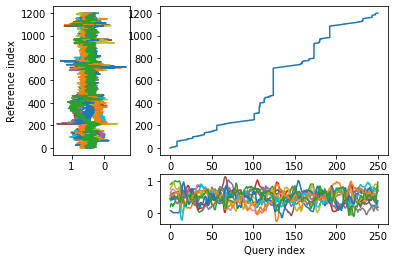

Stretch = 0.75
Distance  = 0.15
Correlation = 0.46


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.61952  1.96813    2.12749  2.73506  2.79482  3.09363  3.24303   
start 2  2.62749  3.40438    4.07171  6.65139  9.13147  9.67928  11.2829   
Adj R^2     0.52     0.30       0.26     0.20     0.51     0.10     0.29   
len 1       0.35     0.16       0.61     0.06     0.30     0.15     0.06   
len 2       0.78     0.67       2.58     2.48     0.55     1.60     0.36   
stretch     0.47     0.71       0.70     0.97     0.38     0.88     0.81   

               8        9  
seg        pause  project  
start 1  3.30279  3.44223  
start 2  11.6414  12.8267  
Adj R^2     0.15     0.47  
len 1       0.14     0.35  
len 2       1.19     0.38  
stretch     0.85     0.06

1      2          3      4      5      6     7      8        9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  project   
corr        0.52   0.30       0.26   0.20   0.51   0.10  0.29   0.15     0.47   
stretch     0.47   0.71       0.70   0.97   0.38   0.88  0.81   0.85     0.06   

           10  
seg       all  
corr     0.46  
stretch  0.75

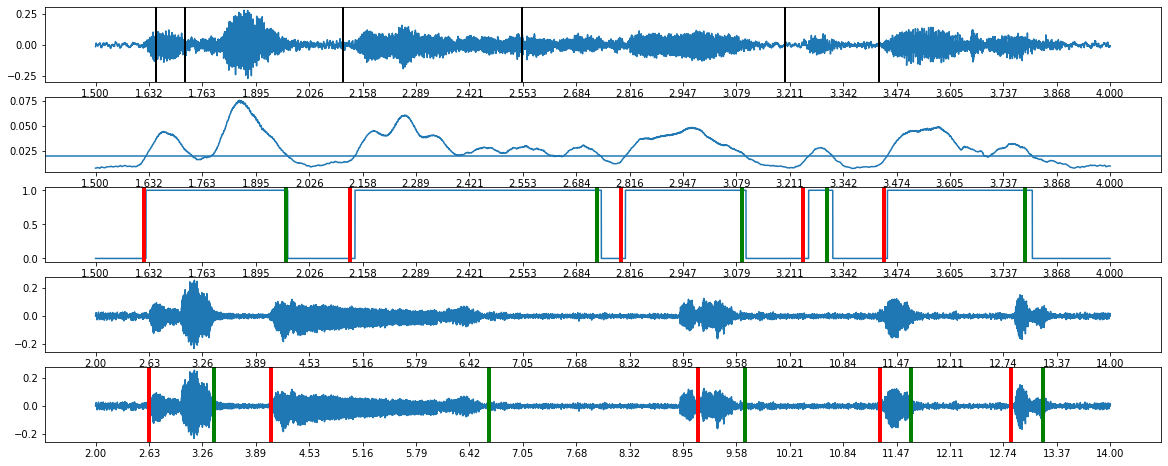

In [27]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-combo2.wav", 2, 14

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, 
       threshold1 = 0.02, timelst1=timelst1)

# 8. normal1normal3

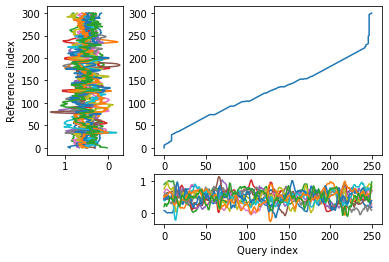

Stretch = 0.12
Distance  = 0.11
Correlation = 0.63


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.61952  1.96813    2.12749  2.73506  2.79482  3.09363  3.24303   
start 2  1.31873  1.65737    1.75697   2.2251   2.2749  2.48406  2.56375   
Adj R^2     0.69     0.31       0.57     0.41     0.71     0.35     0.32   
len 1       0.35     0.16       0.61     0.06     0.30     0.15     0.06   
len 2       0.34     0.10       0.47     0.05     0.21     0.08     0.05   
stretch     0.02     0.32       0.18     0.00     0.24     0.41     0.15   

               8        9  
seg        pause  project  
start 1  3.30279  3.44223  
start 2  2.61355  2.75299  
Adj R^2     0.33     0.60  
len 1       0.14     0.35  
len 2       0.14     0.35  
stretch     0.00     0.00

1      2          3      4      5      6     7      8        9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  project   
corr        0.69   0.31       0.57   0.41   0.71   0.35  0.32   0.33     0.60   
stretch     0.02   0.32       0.18   0.00   0.24   0.41  0.15   0.00     0.00   

           10  
seg       all  
corr     0.63  
stretch  0.12

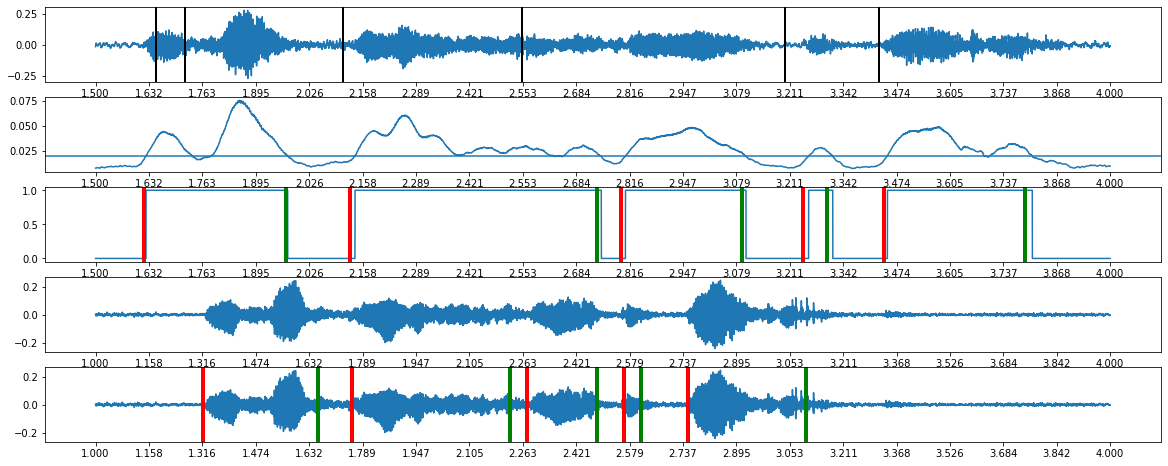

In [28]:
file1, seg1_1, seg1_2 = "report-normal1.wav", 1.5, 4
file2, seg2_1, seg2_2 = "report-normal3.wav", 1, 4

timelst1 = [1.65, 1.72, 2.11, 2.55, 3.2, 3.43]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, 
       threshold1=0.02, 
      timelst1=timelst1) # unit for input_min_pause = ms 

# 9. normal2normal3

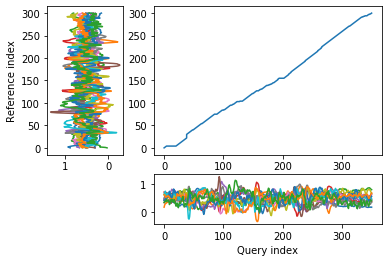

Stretch = 0.13
Distance  = 0.09
Correlation = 0.69


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.88889  2.27778    2.37749  3.01567  3.05556  3.41453  3.55413   
start 2  1.30912  1.67806    1.74786   2.2265  2.26638  2.51567  2.58547   
Adj R^2     0.69     0.38       0.59     0.41     0.67     0.26     0.34   
len 1       0.39     0.10       0.64     0.04     0.36     0.14     0.07   
len 2       0.37     0.07       0.48     0.04     0.25     0.07     0.08   
stretch     0.04     0.17       0.19     0.00     0.24     0.56     0.11   

               8        9  
seg        pause  project  
start 1  3.62393  3.69373  
start 2  2.66524  2.74501  
Adj R^2     0.48     0.68  
len 1       0.07     0.62  
len 2       0.08     0.66  
stretch     0.11     0.04

1      2          3      4      5      6     7      8        9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  project   
corr        0.69   0.38       0.59   0.41   0.67   0.26  0.34   0.48     0.68   
stretch     0.04   0.17       0.19   0.00   0.24   0.56  0.11   0.11     0.04   

           10  
seg       all  
corr     0.69  
stretch  0.13

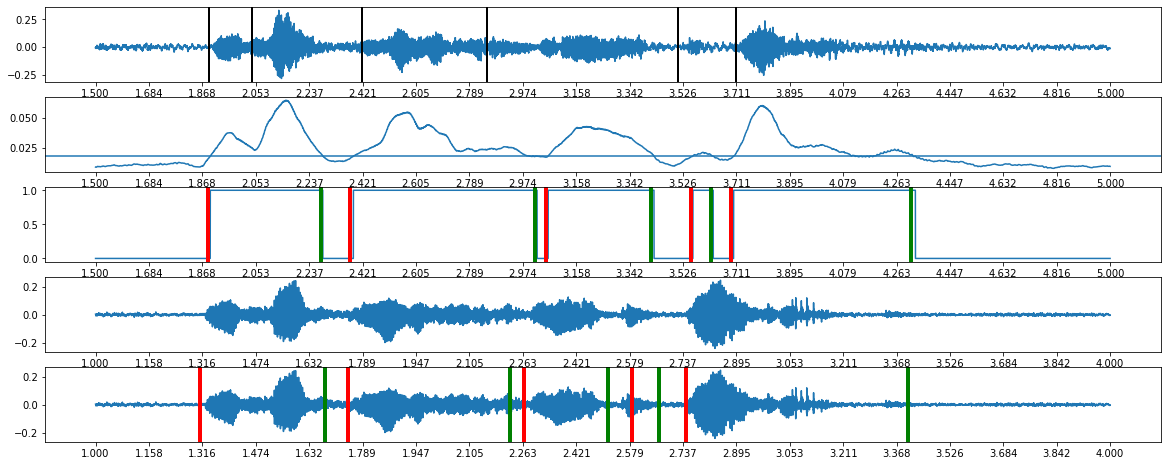

In [29]:
window_len = 100

file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 5
file2, seg2_1, seg2_2 = "report-normal3.wav", 1, 4

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, 
       threshold1=0.018, timelst1 = timelst1, segments = segments1, input_min_pause = 30) # unit for input_min_pause =  ms 

# 10. normal2pause1

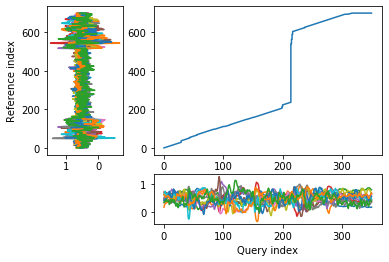

Stretch = 0.89
Distance  = 0.14
Correlation = 0.27


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.88889  2.27778    2.37749  3.01567  3.05556  3.41453  3.55413   
start 2  1.96866  2.40741    2.48718  3.08547  3.12536  3.48433  3.78348   
Adj R^2     0.61     0.32       0.53     0.14     0.09     0.10     0.09   
len 1       0.39     0.10       0.64     0.04     0.36     0.14     0.07   
len 2       0.44     0.08       0.60     0.04     0.36     0.30     0.07   
stretch     0.09     0.17       0.06     0.00     0.00     0.47     0.00   

               8        9  
seg        pause  project  
start 1  3.62393  3.69373  
start 2  3.85328  7.55271  
Adj R^2     0.16     0.56  
len 1       0.07     0.62  
len 2       3.70     0.64  
stretch     0.98     0.02

1      2          3      4      5      6     7      8        9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  project   
corr        0.61   0.32       0.53   0.14   0.09   0.10  0.09   0.16     0.56   
stretch     0.09   0.17       0.06   0.00   0.00   0.47  0.00   0.98     0.02   

           10  
seg       all  
corr     0.27  
stretch  0.89

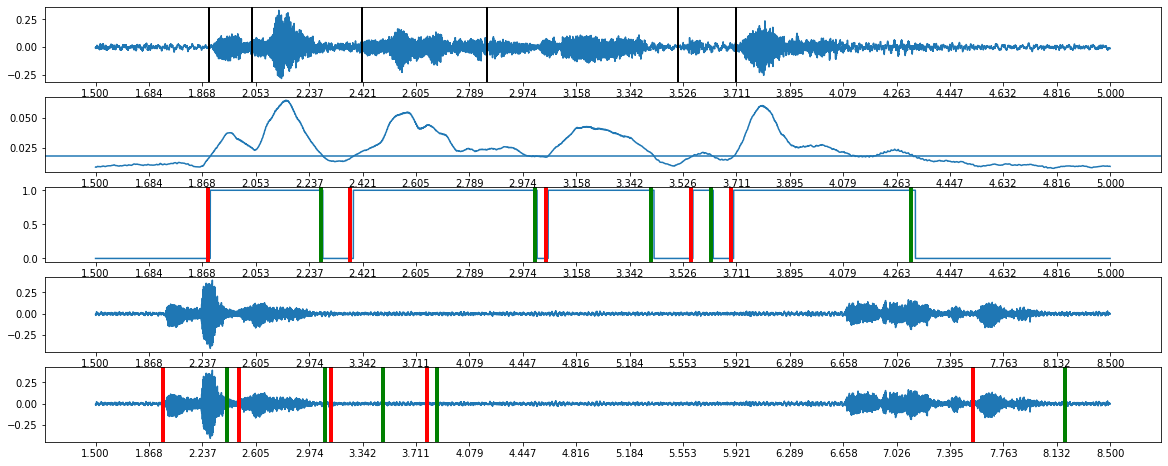

In [30]:
file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 5
file2, seg2_1, seg2_2 = "report-pause1.wav", 1.5, 8.5

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]
timelst2 = [1.99, 2.15, 2.47, 6.66, 7.35, 7.56]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.018,
      timelst1=timelst1, segments = segments1, input_min_pause = 30)

# 11. normal2pause2   isinreport

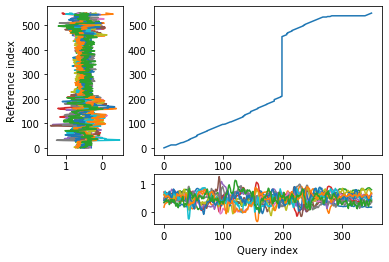

Stretch = 0.75
Distance  = 0.11
Correlation = 0.61


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.88889  2.27778    2.37749  3.01567  3.05556  3.41453  3.55413   
start 2  1.28917  1.74786    1.84758  2.53561   2.5755  3.02422  5.59687   
Adj R^2     0.63     0.30       0.59     0.50     0.66     0.25     0.28   
len 1       0.39     0.10       0.64     0.04     0.36     0.14     0.07   
len 2       0.46     0.10       0.69     0.04     0.45     2.57     0.13   
stretch     0.12     0.00       0.14     0.00     0.15     0.93     0.41   

               8        9  
seg        pause  project  
start 1  3.62393  3.69373  
start 2   5.7265  5.81624  
Adj R^2     0.46     0.58  
len 1       0.07     0.62  
len 2       0.09     0.55  
stretch     0.19     0.15

1      2          3      4      5      6     7      8        9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  project   
corr        0.63   0.30       0.59   0.50   0.66   0.25  0.28   0.46     0.58   
stretch     0.12   0.00       0.14   0.00   0.15   0.93  0.41   0.19     0.15   

           10  
seg       all  
corr     0.61  
stretch  0.75

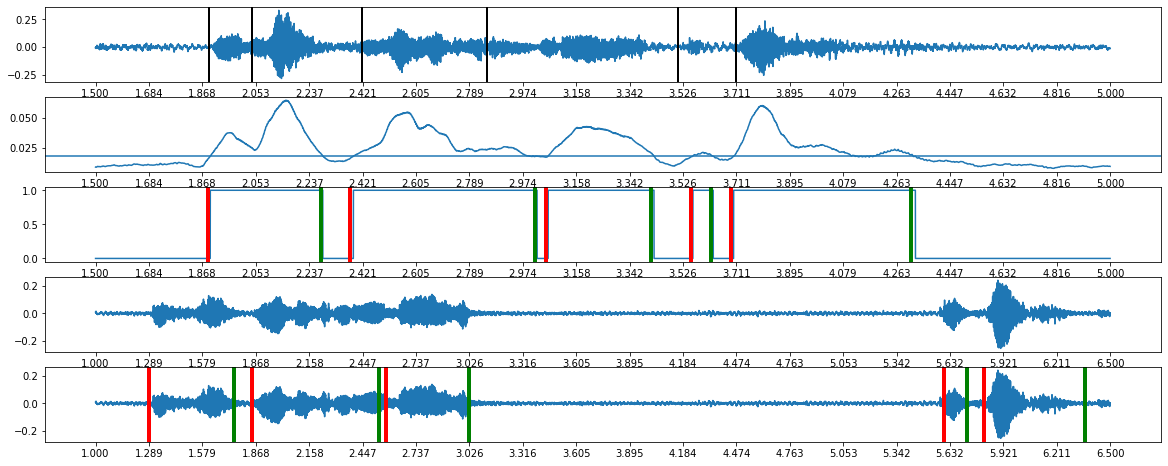

In [31]:
window_len = 100

file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 5
file2, seg2_1, seg2_2 = "report-pause2.wav", 1, 6.5

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.018,
      timelst1=timelst1, segments = segments1, input_min_pause = 30)

# 12. normal2longword1 isinreport

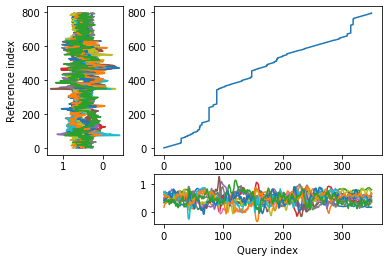

Stretch = 0.62
Distance  = 0.12
Correlation = 0.47


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.88889  2.27778    2.37749  3.01567  3.05556  3.41453  3.55413   
start 2  1.67806  3.38319    3.56268  5.55698  5.60684  6.24501  6.44444   
Adj R^2     0.44     0.08       0.47     0.00     0.54     0.16     0.36   
len 1       0.39     0.10       0.64     0.04     0.36     0.14     0.07   
len 2       1.71     0.18       1.99     0.05     0.64     0.20     0.12   
stretch     0.73     0.43       0.63     0.25     0.41     0.30     0.42   

               8        9  
seg        pause  project  
start 1  3.62393  3.69373  
start 2   6.5641   6.6339  
Adj R^2     0.42     0.55  
len 1       0.07     0.62  
len 2       0.07     0.63  
stretch     0.08     0.11

1      2          3      4      5      6     7      8        9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  project   
corr        0.44   0.08       0.47   0.00   0.54   0.16  0.36   0.42     0.55   
stretch     0.73   0.43       0.63   0.25   0.41   0.30  0.42   0.08     0.11   

           10  
seg       all  
corr     0.47  
stretch  0.62

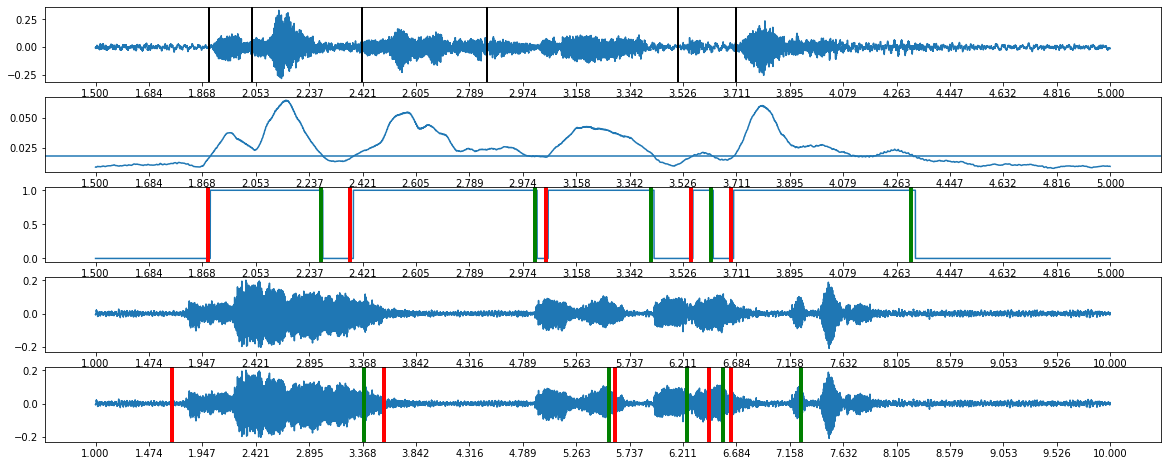

In [32]:
file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 5
file2, seg2_1, seg2_2 = "report-longword1.wav", 1, 10

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.018,
      timelst1=timelst1, segments = segments1, input_min_pause = 30)

# 13. normal2longword2

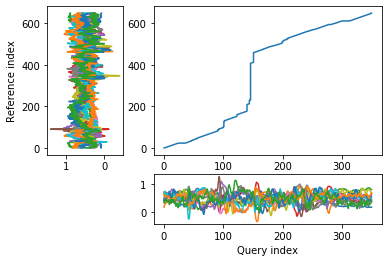

Stretch = 0.64
Distance  = 0.14
Correlation = 0.42


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.88889  2.27778    2.37749  3.01567  3.05556  3.41453  3.55413   
start 2  1.75926  2.18803    2.28775  6.08689  6.12678  6.46581  6.70513   
Adj R^2     0.61     0.31       0.23     0.45     0.66     0.36     0.33   
len 1       0.39     0.10       0.64     0.04     0.36     0.14     0.07   
len 2       0.43     0.10       3.80     0.04     0.34     0.24     0.11   
stretch     0.07     0.00       0.78     0.00     0.06     0.35     0.32   

               8        9  
seg        pause  project  
start 1  3.62393  3.69373  
start 2  6.81481  6.88462  
Adj R^2     0.15     0.55  
len 1       0.07     0.62  
len 2       0.07     0.55  
stretch     0.00     0.07

1      2          3      4      5      6     7      8        9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  project   
corr        0.61   0.31       0.23   0.45   0.66   0.36  0.33   0.15     0.55   
stretch     0.07   0.00       0.78   0.00   0.06   0.35  0.32   0.00     0.07   

           10  
seg       all  
corr     0.42  
stretch  0.64

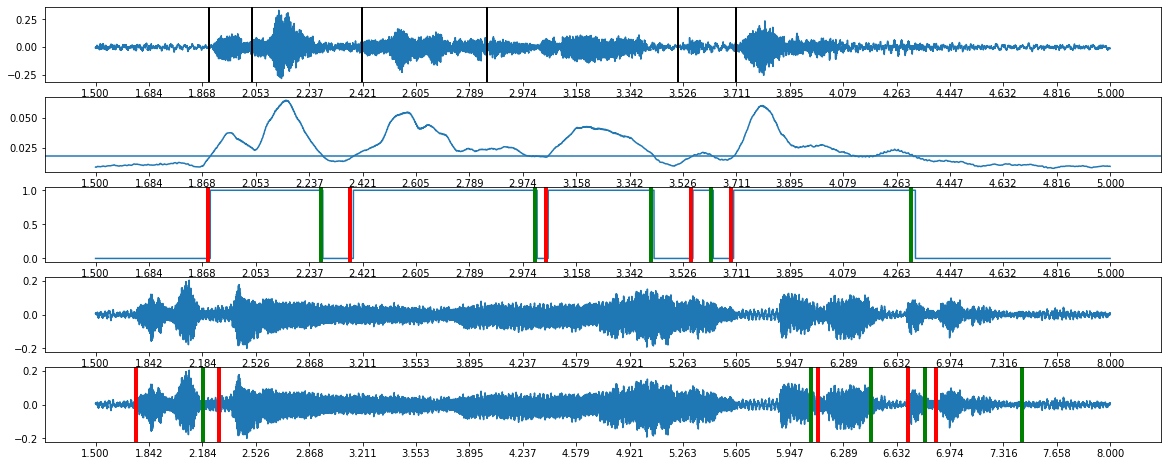

In [33]:
file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 5
file2, seg2_1, seg2_2 = "report-longword2.wav", 1.5, 8

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]
timelst2 = [1.67, 2.06, 6.73, 7.9, 8.54, 8.72]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.018,
      timelst1=timelst1, segments = segments1, input_min_pause = 30)

# 14. normal2combo1 isinreport

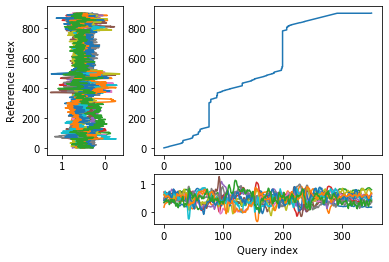

Stretch = 0.74
Distance  = 0.13
Correlation = 0.49


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.88889  2.27778    2.37749  3.01567  3.05556  3.41453  3.55413   
start 2   1.5584  4.02137    4.33048  5.54701  5.62678  6.10541  8.84758   
Adj R^2     0.45     0.18       0.54     0.35     0.61     0.22     0.41   
len 1       0.39     0.10       0.64     0.04     0.36     0.14     0.07   
len 2       2.46     0.31       1.22     0.08     0.48     2.74     0.32   
stretch     0.79     0.62       0.39     0.49     0.20     0.93     0.75   

               8        9  
seg        pause  project  
start 1  3.62393  3.69373  
start 2  9.16667  9.24644  
Adj R^2     0.41     0.57  
len 1       0.07     0.62  
len 2       0.08     0.62  
stretch     0.11     0.02

1      2          3      4      5      6     7      8        9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  project   
corr        0.45   0.18       0.54   0.35   0.61   0.22  0.41   0.41     0.57   
stretch     0.79   0.62       0.39   0.49   0.20   0.93  0.75   0.11     0.02   

           10  
seg       all  
corr     0.49  
stretch  0.74

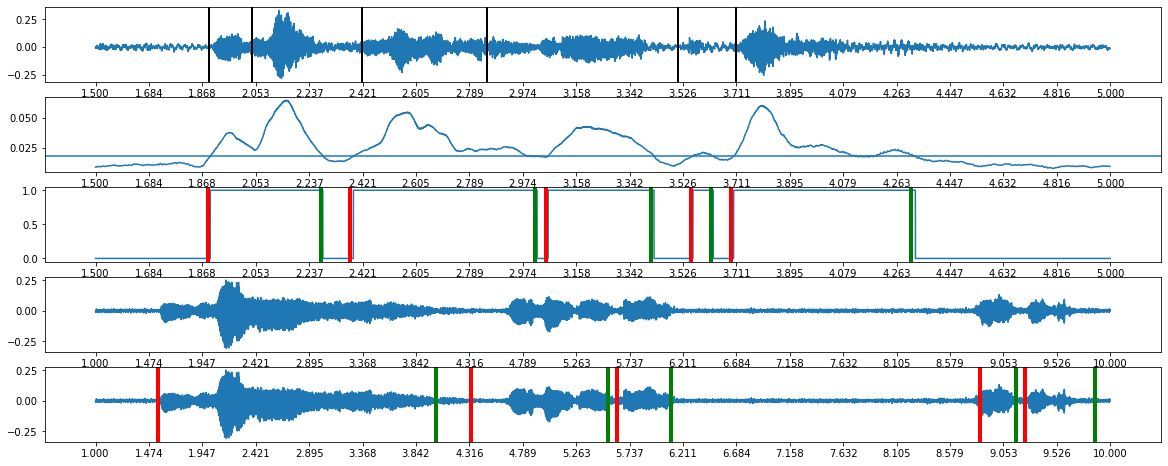

In [34]:
file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 5
file2, seg2_1, seg2_2 = "report-combo1.wav", 1, 10

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.018,
      timelst1=timelst1, segments = segments1, input_min_pause = 30)

# 15. normal2combo2

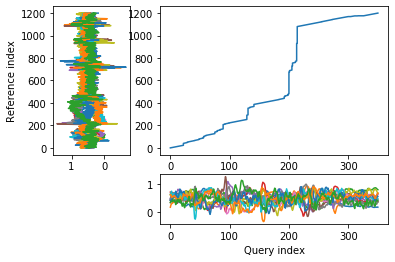

Stretch = 0.84
Distance  = 0.14
Correlation = 0.41


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.88889  2.27778    2.37749  3.01567  3.05556  3.41453  3.55413   
start 2  2.61823   3.4359    3.66524  5.96866  6.00855  6.38746  9.26923   
Adj R^2     0.51     0.18       0.44     0.08     0.18     0.32     0.21   
len 1       0.39     0.10       0.64     0.04     0.36     0.14     0.07   
len 2       0.82     0.23       2.30     0.04     0.38     2.88     0.44   
stretch     0.45     0.51       0.65     0.00     0.04     0.94     0.81   

               8        9  
seg        pause  project  
start 1  3.62393  3.69373  
start 2  9.70798  12.8291  
Adj R^2     0.06     0.55  
len 1       0.07     0.62  
len 2       3.12     0.66  
stretch     0.97     0.07

1      2          3      4      5      6     7      8        9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  project   
corr        0.51   0.18       0.44   0.08   0.18   0.32  0.21   0.06     0.55   
stretch     0.45   0.51       0.65   0.00   0.04   0.94  0.81   0.97     0.07   

           10  
seg       all  
corr     0.41  
stretch  0.84

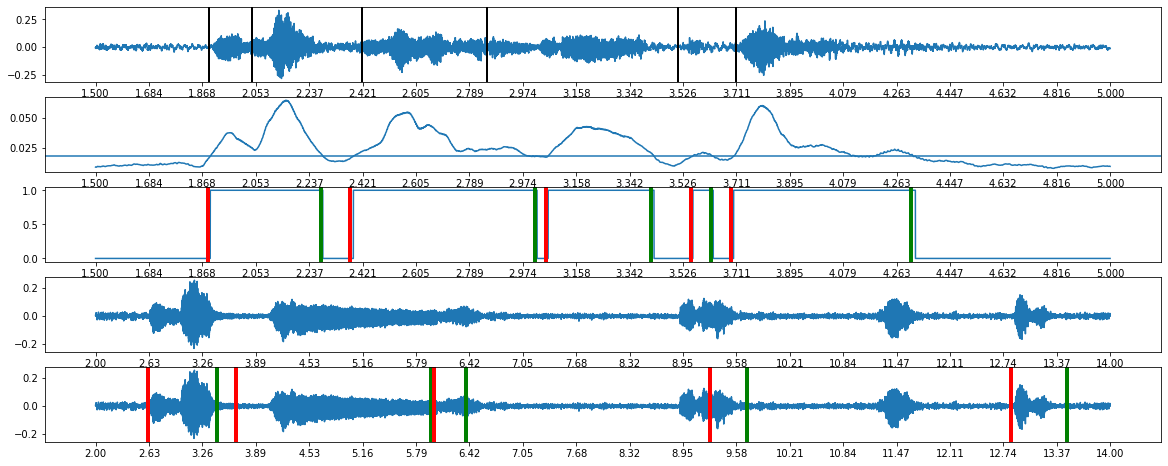

In [35]:
file1, seg1_1, seg1_2 = "report-normal2.wav", 1.5, 5
file2, seg2_1, seg2_2 = "report-combo2.wav", 2, 14

timelst1 = [1.89, 2.04, 2.42, 2.85, 3.51, 3.71]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.018,
      timelst1=timelst1, segments = segments1, input_min_pause = 30)

# 16. normal3pause1

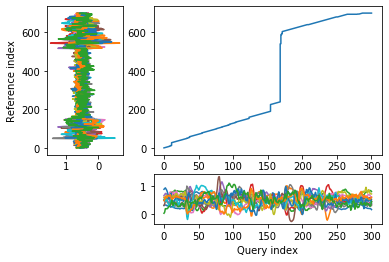

Stretch = 0.89
Distance  = 0.14
Correlation = 0.30


1        2        3        4          5        6        7  \
seg           We    pause     have    pause  really en    pause    joyed   
start 1  1.31894  1.66777  1.74751  2.23588    2.27575  2.48505  2.55482   
start 2  1.97841  2.39701  2.47674  3.09468    3.13455  3.34385  3.76246   
Adj R^2     0.70     0.26     0.52     0.17       0.05     0.07     0.03   
len 1       0.35     0.08     0.49     0.04       0.21     0.07     0.06   
len 2       0.42     0.08     0.62     0.04       0.21     0.42     0.06   
stretch     0.13     0.00     0.16     0.00       0.00     0.81     0.00   

               8        9  
seg        pause      the  
start 1  2.61462  2.73422  
start 2  3.82226  7.54983  
Adj R^2     0.12     0.61  
len 1       0.12     0.38  
len 2       3.73     0.36  
stretch     0.96     0.04

1      2     3      4          5      6      7      8     9     10
seg        We  pause  have  pause  really en  pause  joyed  pause   the   all
corr     0.70   0.26  0.52   0.17       0.05   0.07   0.03   0.12  0.61  0.30
stretch  0.13   0.00  0.16   0.00       0.00   0.81   0.00   0.96  0.04  0.89

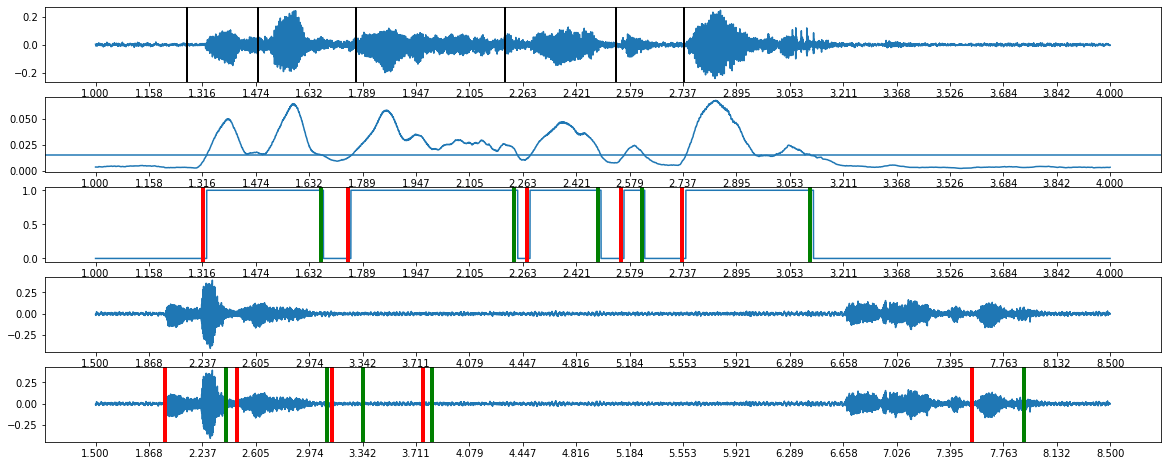

In [36]:
window_len = 50

file1, seg1_1, seg1_2 = "report-normal3.wav", 1, 4
file2, seg2_1, seg2_2 = "report-pause1.wav", 1.5, 8.5

timelst1 = [1.27, 1.48, 1.77, 2.21, 2.54, 2.74]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.015,
      timelst1=timelst1, segments = segmentsnormal3, input_min_pause = 30)

# 17. normal3pause2

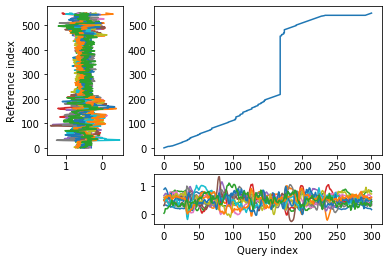

Stretch = 0.82
Distance  = 0.12
Correlation = 0.60


1        2        3        4          5        6        7  \
seg           We    pause     have    pause  really en    pause    joyed   
start 1  1.31894  1.66777  1.74751  2.23588    2.27575  2.48505  2.55482   
start 2  1.28904  1.72757  1.85714  2.55482    2.63455  2.98339  3.05316   
Adj R^2     0.68     0.39     0.61     0.27       0.68     0.34     0.37   
len 1       0.35     0.08     0.49     0.04       0.21     0.07     0.06   
len 2       0.44     0.13     0.70     0.08       0.35     0.07     0.06   
stretch     0.16     0.34     0.24     0.49       0.33     0.00     0.00   

               8        9  
seg        pause      the  
start 1  2.61462  2.73422  
start 2  3.11296  5.68439  
Adj R^2     0.17     0.56  
len 1       0.12     0.38  
len 2       2.57     0.52  
stretch     0.94     0.21

1      2     3      4          5      6      7      8     9     10
seg        We  pause  have  pause  really en  pause  joyed  pause   the   all
corr     0.68   0.39  0.61   0.27       0.68   0.34   0.37   0.17  0.56  0.60
stretch  0.16   0.34  0.24   0.49       0.33   0.00   0.00   0.94  0.21  0.82

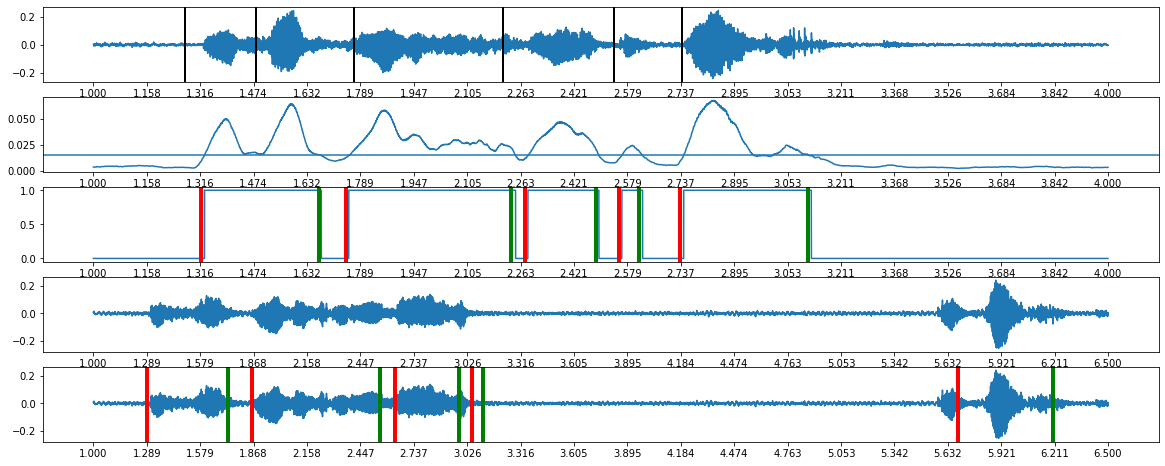

In [37]:
file1, seg1_1, seg1_2 = "report-normal3.wav", 1, 4
file2, seg2_1, seg2_2 = "report-pause2.wav", 1, 6.5

timelst1 = [1.27, 1.48, 1.77, 2.21, 2.54, 2.74]
output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.015,
      timelst1=timelst1, segments = segmentsnormal3, input_min_pause = 30)

# 18. normal3longword1

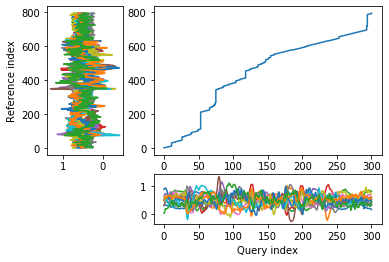

Stretch = 0.71
Distance  = 0.13
Correlation = 0.49


1        2        3        4          5        6        7  \
seg           We    pause     have    pause  really en    pause    joyed   
start 1  1.31894  1.66777  1.74751  2.23588    2.27575  2.48505  2.55482   
start 2  1.70764  3.36213  3.65116  5.56478    5.65449  6.18272  6.41196   
Adj R^2     0.52     0.21     0.43     0.36       0.47     0.27     0.32   
len 1       0.35     0.08     0.49     0.04       0.21     0.07     0.06   
len 2       1.65     0.29     1.91     0.09       0.53     0.23     0.10   
stretch     0.75     0.70     0.70     0.58       0.57     0.68     0.41   

               8        9  
seg        pause      the  
start 1  2.61462  2.73422  
start 2  6.51163  6.63123  
Adj R^2     0.38     0.64  
len 1       0.12     0.38  
len 2       0.12     0.39  
stretch     0.08     0.16

1      2     3      4          5      6      7      8     9     10
seg        We  pause  have  pause  really en  pause  joyed  pause   the   all
corr     0.52   0.21  0.43   0.36       0.47   0.27   0.32   0.38  0.64  0.49
stretch  0.75   0.70  0.70   0.58       0.57   0.68   0.41   0.08  0.16  0.71

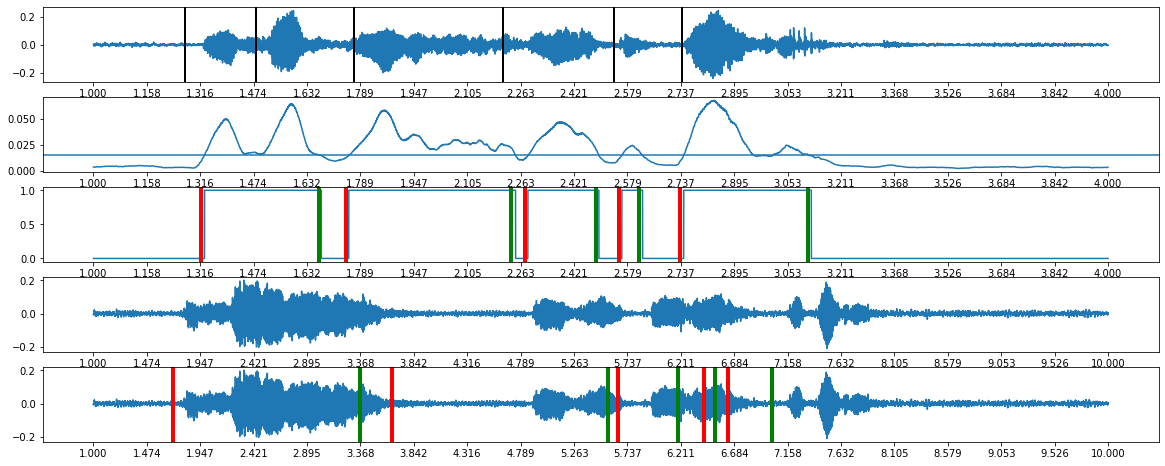

In [38]:
file1, seg1_1, seg1_2 = "report-normal3.wav", 1, 4
file2, seg2_1, seg2_2 = "report-longword1.wav", 1, 10

timelst1 = [1.27, 1.48, 1.77, 2.21, 2.54, 2.74]
output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.015,
      timelst1=timelst1, segments = segmentsnormal3, input_min_pause = 30)

# 19. normal3longword2

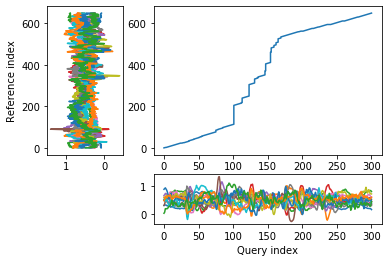

Stretch = 0.64
Distance  = 0.14
Correlation = 0.38


1        2        3        4          5        6        7  \
seg           We    pause     have    pause  really en    pause    joyed   
start 1  1.31894  1.66777  1.74751  2.23588    2.27575  2.48505  2.55482   
start 2  1.77907  2.18771  2.26744  4.54983     4.5897  5.55648  6.31395   
Adj R^2     0.58     0.21     0.39     0.37       0.34     0.15     0.18   
len 1       0.35     0.08     0.49     0.04       0.21     0.07     0.06   
len 2       0.41     0.08     2.28     0.04       0.97     0.76     0.14   
stretch     0.11     0.00     0.73     0.00       0.73     0.89     0.53   

               8        9  
seg        pause      the  
start 1  2.61462  2.73422  
start 2  6.45349  6.88206  
Adj R^2     0.14     0.40  
len 1       0.12     0.38  
len 2       0.43     0.34  
stretch     0.67     0.08

1      2     3      4          5      6      7      8     9     10
seg        We  pause  have  pause  really en  pause  joyed  pause   the   all
corr     0.58   0.21  0.39   0.37       0.34   0.15   0.18   0.14  0.40  0.38
stretch  0.11   0.00  0.73   0.00       0.73   0.89   0.53   0.67  0.08  0.64

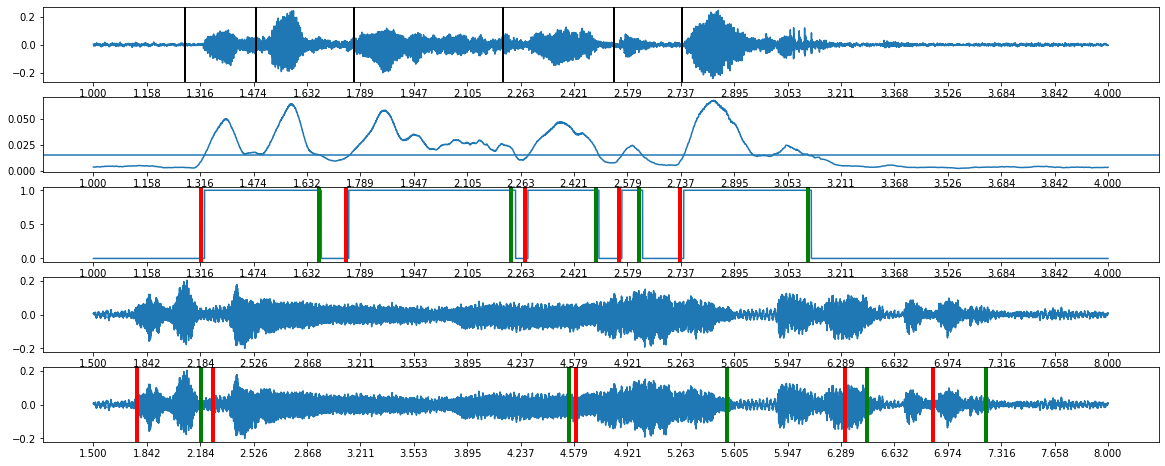

In [39]:
file1, seg1_1, seg1_2 = "report-normal3.wav", 1, 4
file2, seg2_1, seg2_2 = "report-longword2.wav", 1.5, 8

timelst1 = [1.27, 1.48, 1.77, 2.21, 2.54, 2.74]
output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.015,
      timelst1=timelst1, segments = segmentsnormal3, input_min_pause = 30)

# 20. normal3combo1

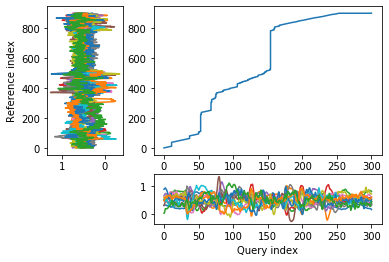

Stretch = 0.82
Distance  = 0.14
Correlation = 0.49


1        2        3        4          5        6        7  \
seg           We    pause     have    pause  really en    pause    joyed   
start 1  1.31894  1.66777  1.74751  2.23588    2.27575  2.48505  2.55482   
start 2  1.57807  3.49169  4.37874  5.57475    5.65449  6.13289  8.81395   
Adj R^2     0.47     0.12     0.50     0.23       0.51     0.08     0.43   
len 1       0.35     0.08     0.49     0.04       0.21     0.07     0.06   
len 2       1.91     0.89     1.20     0.08       0.48     2.68     0.25   
stretch     0.77     0.89     0.51     0.49       0.49     0.97     0.73   

               8        9  
seg        pause      the  
start 1  2.61462  2.73422  
start 2  9.06312  9.23256  
Adj R^2     0.35     0.60  
len 1       0.12     0.38  
len 2       0.17     0.37  
stretch     0.24     0.06

1      2     3      4          5      6      7      8     9     10
seg        We  pause  have  pause  really en  pause  joyed  pause   the   all
corr     0.47   0.12  0.50   0.23       0.51   0.08   0.43   0.35  0.60  0.49
stretch  0.77   0.89  0.51   0.49       0.49   0.97   0.73   0.24  0.06  0.82

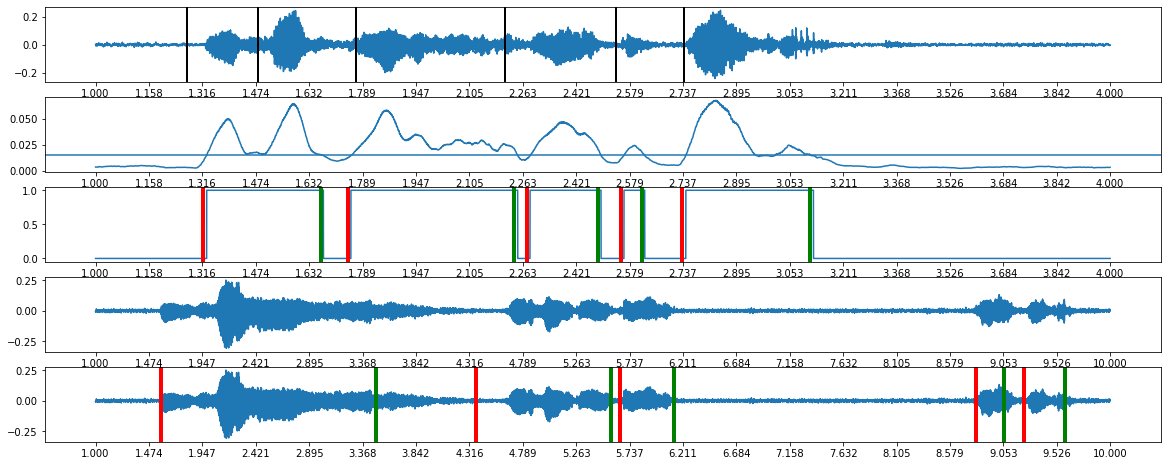

In [40]:
file1, seg1_1, seg1_2 = "report-normal3.wav", 1, 4
file2, seg2_1, seg2_2 = "report-combo1.wav", 1, 10

timelst1 = [1.27, 1.48, 1.77, 2.21, 2.54, 2.74]
timelst2 = [1.50, 2.01, 4.69, 5.24, 8.80, 9.30]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.015,
      timelst1=timelst1, segments = segmentsnormal3, input_min_pause = 30)

# 21. normal3combo2

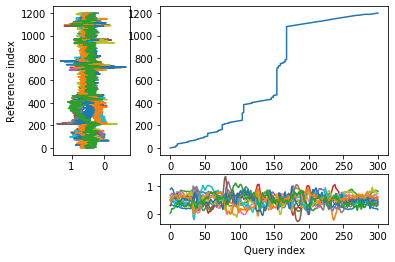

Stretch = 0.87
Distance  = 0.14
Correlation = 0.43


1        2        3        4          5        6        7  \
seg           We    pause     have    pause  really en    pause    joyed   
start 1  1.31894  1.66777  1.74751  2.23588    2.27575  2.48505  2.55482   
start 2  2.63787  3.41528  3.63455  6.08638    6.12625  6.50498  9.09635   
Adj R^2     0.56     0.28     0.46     0.23       0.26     0.09     0.22   
len 1       0.35     0.08     0.49     0.04       0.21     0.07     0.06   
len 2       0.78     0.22     2.45     0.04       0.38     2.59     0.41   
stretch     0.47     0.59     0.74     0.00       0.38     0.97     0.83   

               8        9  
seg        pause      the  
start 1  2.61462  2.73422  
start 2  9.50498  12.8239  
Adj R^2     0.08     0.52  
len 1       0.12     0.38  
len 2       3.32     0.37  
stretch     0.95     0.02

1      2     3      4          5      6      7      8     9     10
seg        We  pause  have  pause  really en  pause  joyed  pause   the   all
corr     0.56   0.28  0.46   0.23       0.26   0.09   0.22   0.08  0.52  0.43
stretch  0.47   0.59  0.74   0.00       0.38   0.97   0.83   0.95  0.02  0.87

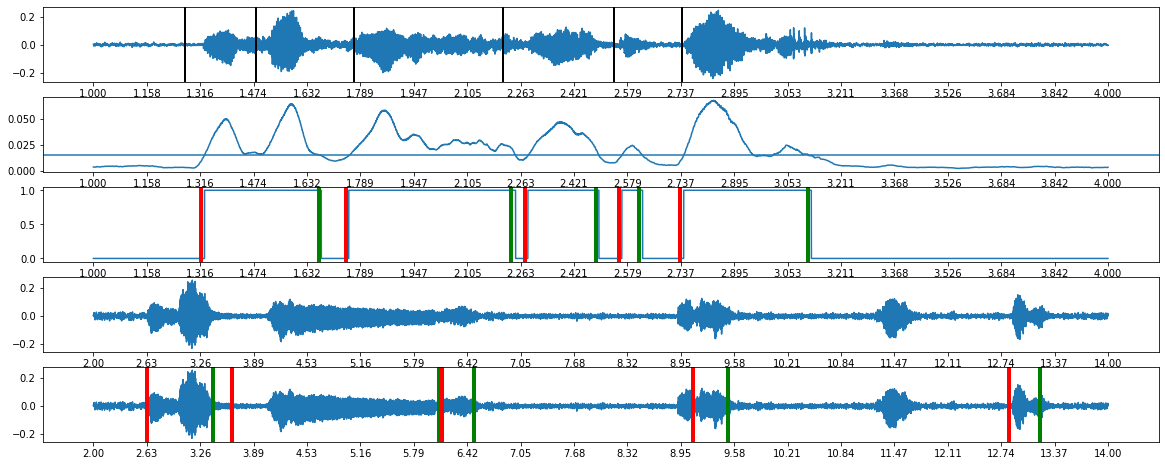

In [41]:
file1, seg1_1, seg1_2 = "report-normal3.wav", 1, 4
file2, seg2_1, seg2_2 = "report-combo2.wav", 2, 14

timelst1 = [1.27, 1.48, 1.77, 2.21, 2.54, 2.74]
output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.015,
      timelst1=timelst1, segments = segmentsnormal3, input_min_pause = 30)

# 22. pause1pause2

In [42]:
segmentspause1 = ['We have', 'pause', 'really', 'pause', 'enjoyed', 'pause', 'the', 'pause', 'pro', 'pause', 'ject', '','', '', '','', '', '']

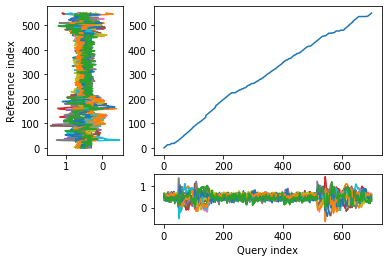

Stretch = 0.17
Distance  = 0.12
Correlation = 0.35


1        2        3        4        5        6       7   \
seg      We have    pause   really    pause  enjoyed    pause     the   
start 1  1.96933  2.41869  2.46862  2.93795  6.65264  7.27175  7.3816   
start 2  1.28959  1.75892  1.81883  2.34807  5.36377  5.73324  5.7632   
Adj R^2     0.64     0.40     0.62     0.09     0.22     0.21    0.07   
len 1       0.45     0.05     0.47     3.71     0.62     0.11    0.08   
len 2       0.47     0.06     0.53     3.02     0.37     0.03    0.03   
stretch     0.03     0.15     0.14     0.17     0.33     0.62    0.49   

              8        9        10       11  
seg        pause      pro    pause     ject  
start 1  7.46148  7.56134  7.77104  7.83096  
start 2  5.79315  5.81312   6.0428  6.10271  
Adj R^2     0.07     0.58     0.70     0.33  
len 1       0.10     0.21     0.06     0.13  
len 2       0.02     0.23     0.06     0.15  
stretch     0.85     0.07     0.00     0.11

1      2       3      4        5      6     7      8     9   \
seg      We have  pause  really  pause  enjoyed  pause   the  pause   pro   
corr        0.64   0.40    0.62   0.09     0.22   0.21  0.07   0.07  0.58   
stretch     0.03   0.15    0.14   0.17     0.33   0.62  0.49   0.85  0.07   

            10    11    12  
seg      pause  ject   all  
corr      0.70  0.33  0.35  
stretch   0.00  0.11  0.17

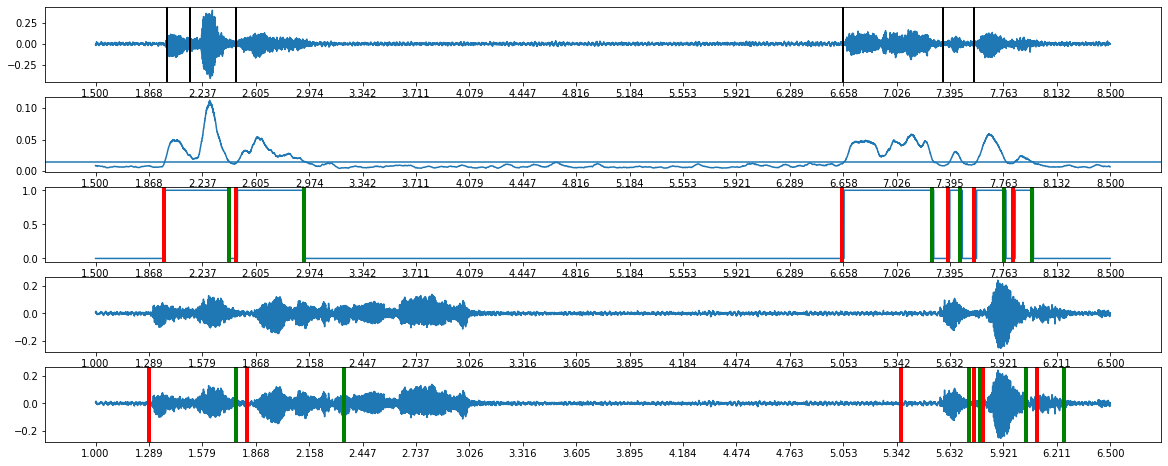

In [43]:
window_len = 50

file1, seg1_1, seg1_2 = "report-pause1.wav", 1.5, 8.5
file2, seg2_1, seg2_2 = "report-pause2.wav", 1, 6.5

timelst1 = [1.99, 2.15, 2.47, 6.66, 7.35, 7.56]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.015,
      timelst1=timelst1, segments = segmentspause1, input_min_pause = 30)

# 23. pause1longword1

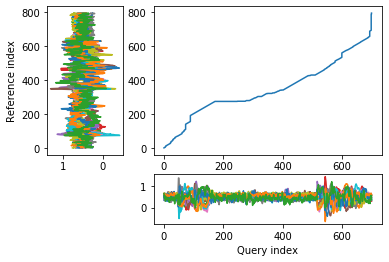

Stretch = 0.51
Distance  = 0.13
Correlation = 0.34


1        2        3        4        5        6        7   \
seg      We have    pause   really    pause  enjoyed    pause      the   
start 1  1.96933  2.41869  2.46862  2.93795  6.65264  7.27175   7.3816   
start 2    1.699  2.92725  2.97718   3.4465  5.33381  6.10271  6.20257   
Adj R^2     0.46     0.34     0.15     0.06     0.56     0.10     0.16   
len 1       0.45     0.05     0.47     3.71     0.62     0.11     0.08   
len 2       1.23     0.05     0.47     1.89     0.77     0.10     0.08   
stretch     0.59     0.08     0.08     0.45     0.21     0.14     0.08   

              8        9        10       11  
seg        pause      pro    pause     ject  
start 1  7.46148  7.56134  7.77104  7.83096  
start 2  6.28245  6.64194  6.83167  6.89158  
Adj R^2     0.06     0.59     0.63     0.50  
len 1       0.10     0.21     0.06     0.13  
len 2       0.36     0.19     0.06     0.15  
stretch     0.70     0.14     0.08     0.17

1      2       3      4        5      6     7      8     9   \
seg      We have  pause  really  pause  enjoyed  pause   the  pause   pro   
corr        0.46   0.34    0.15   0.06     0.56   0.10  0.16   0.06  0.59   
stretch     0.59   0.08    0.08   0.45     0.21   0.14  0.08   0.70  0.14   

            10    11    12  
seg      pause  ject   all  
corr      0.63  0.50  0.34  
stretch   0.08  0.17  0.51

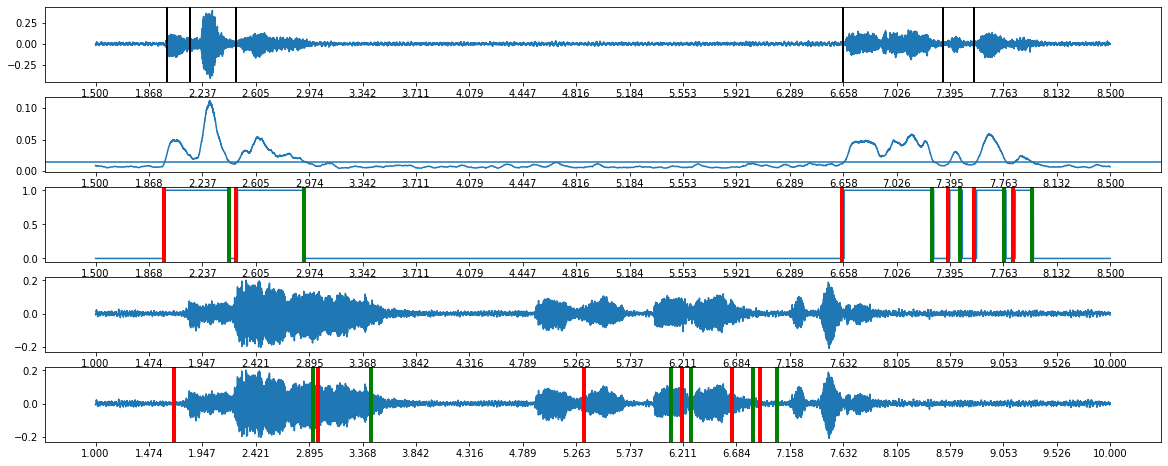

In [44]:
file1, seg1_1, seg1_2 = "report-pause1.wav", 1.5, 8.5
file2, seg2_1, seg2_2 = "report-longword1.wav", 1, 10

timelst1 = [1.99, 2.15, 2.47, 6.66, 7.35, 7.56]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.015,
      timelst1=timelst1, segments = segmentspause1, input_min_pause = 30)

# 24. pause1longword2

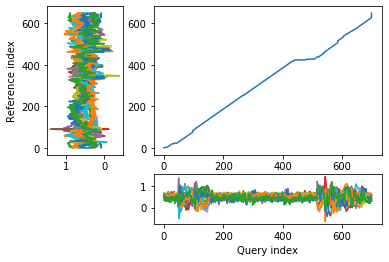

Stretch = 0.04
Distance  = 0.16
Correlation = 0.19


1        2        3        4        5        6       7   \
seg      We have    pause   really    pause  enjoyed    pause     the   
start 1  1.96933  2.41869  2.46862  2.93795  6.65264  7.27175  7.3816   
start 2  1.75963  2.20899  2.25892  2.80813  5.86377  6.48288  6.6826   
Adj R^2     0.61     0.21     0.34     0.02     0.69     0.22    0.19   
len 1       0.45     0.05     0.47     3.71     0.62     0.11    0.08   
len 2       0.45     0.05     0.55     3.06     0.62     0.20    0.08   
stretch     0.00     0.00     0.11     0.13     0.09     0.39    0.00   

              8        9        10       11  
seg        pause      pro    pause     ject  
start 1  7.46148  7.56134  7.77104  7.83096  
start 2  6.76248   6.8923  7.08203  7.12197  
Adj R^2     0.18     0.35     0.48     0.53  
len 1       0.10     0.21     0.06     0.13  
len 2       0.13     0.19     0.04     0.12  
stretch     0.19     0.07     0.15     0.06

1      2       3      4        5      6     7      8     9   \
seg      We have  pause  really  pause  enjoyed  pause   the  pause   pro   
corr        0.61   0.21    0.34   0.02     0.69   0.22  0.19   0.18  0.35   
stretch     0.00   0.00    0.11   0.13     0.09   0.39  0.00   0.19  0.07   

            10    11    12  
seg      pause  ject   all  
corr      0.48  0.53  0.19  
stretch   0.15  0.06  0.04

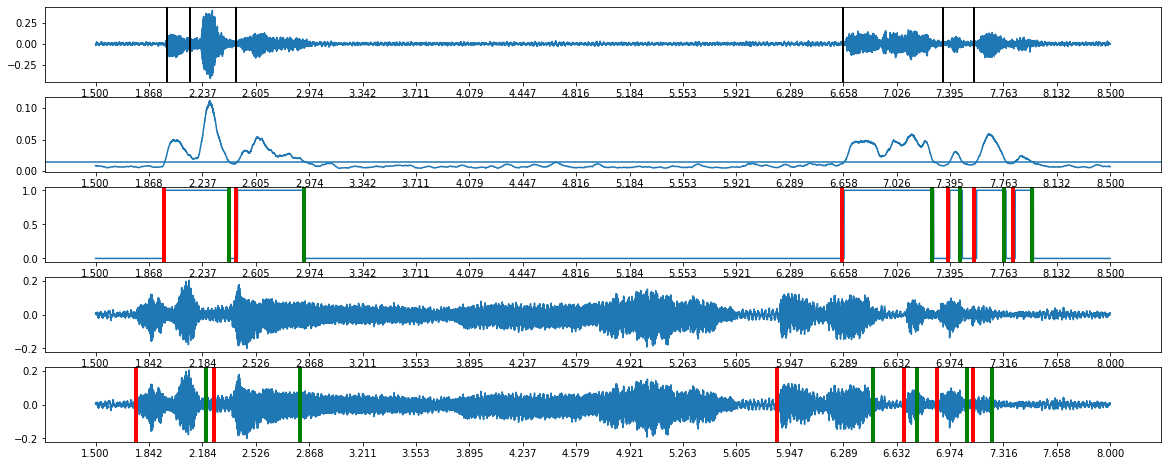

In [45]:
file1, seg1_1, seg1_2 = "report-pause1.wav", 1.5, 8.5
file2, seg2_1, seg2_2 = "report-longword2.wav", 1.5, 8

timelst1 = [1.99, 2.15, 2.47, 6.66, 7.35, 7.56]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.015,
      timelst1=timelst1, segments = segmentspause1, input_min_pause = 30)

# 25. pause1combo1

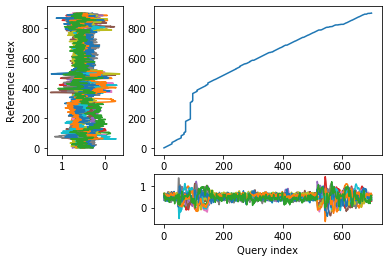

Stretch = 0.26
Distance  = 0.14
Correlation = 0.35


1        2        3        4        5        6        7   \
seg      We have    pause   really    pause  enjoyed    pause      the   
start 1  1.96933  2.41869  2.46862  2.93795  6.65264  7.27175   7.3816   
start 2  1.56919  4.05563  4.14551  5.19401  8.79886   9.1883  9.20827   
Adj R^2     0.45     0.14     0.41     0.15     0.12     0.08     0.37   
len 1       0.45     0.05     0.47     3.71     0.62     0.11     0.08   
len 2       2.49     0.09     1.05     3.60     0.39     0.02     0.03   
stretch     0.77     0.41     0.47     0.09     0.30     0.74     0.64   

              8        9        10       11  
seg        pause      pro    pause     ject  
start 1  7.46148  7.56134  7.77104  7.83096  
start 2  9.23823   9.2582  9.45792  9.50785  
Adj R^2     0.07     0.49     0.59     0.40  
len 1       0.10     0.21     0.06     0.13  
len 2       0.02     0.20     0.05     0.13  
stretch     0.85     0.04     0.00     0.00

1      2       3      4        5      6     7      8     9   \
seg      We have  pause  really  pause  enjoyed  pause   the  pause   pro   
corr        0.45   0.14    0.41   0.15     0.12   0.08  0.37   0.07  0.49   
stretch     0.77   0.41    0.47   0.09     0.30   0.74  0.64   0.85  0.04   

            10    11    12  
seg      pause  ject   all  
corr      0.59  0.40  0.35  
stretch   0.00  0.00  0.26

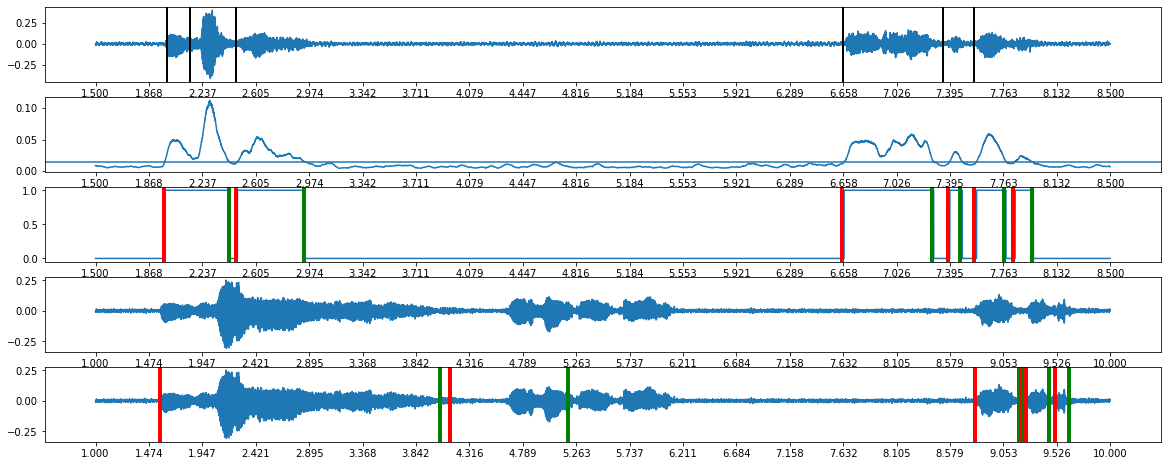

In [46]:
file1, seg1_1, seg1_2 = "report-pause1.wav", 1.5, 8.5
file2, seg2_1, seg2_2 = "report-combo1.wav", 1, 10

timelst1 = [1.99, 2.15, 2.47, 6.66, 7.35, 7.56]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.015,
      timelst1=timelst1, segments = segmentspause1, input_min_pause = 30)

# 26. pause1combo2

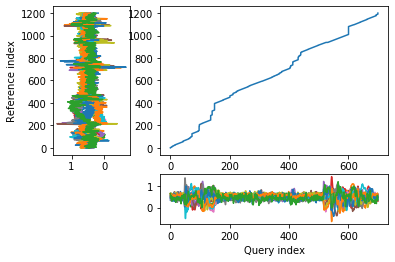

Stretch = 0.36
Distance  = 0.13
Correlation = 0.36


1        2        3        4        5        6        7   \
seg      We have    pause   really    pause  enjoyed    pause      the   
start 1  1.96933  2.41869  2.46862  2.93795  6.65264  7.27175   7.3816   
start 2  2.63909  3.45792   3.5378  5.30528  11.2967  11.8459  11.9558   
Adj R^2     0.54     0.29     0.46     0.32     0.09     0.02     0.18   
len 1       0.45     0.05     0.47     3.71     0.62     0.11     0.08   
len 2       0.82     0.08     1.77     5.99     0.55     0.11     0.08   
stretch     0.37     0.35     0.67     0.31     0.08     0.00     0.00   

              8        9        10       11  
seg        pause      pro    pause     ject  
start 1  7.46148  7.56134  7.77104  7.83096  
start 2  12.0357  12.8445  13.0342  13.1041  
Adj R^2     0.11     0.42     0.53     0.53  
len 1       0.10     0.21     0.06     0.13  
len 2       0.81     0.19     0.07     0.14  
stretch     0.85     0.07     0.12     0.06

1      2       3      4        5      6     7      8     9   \
seg      We have  pause  really  pause  enjoyed  pause   the  pause   pro   
corr        0.54   0.29    0.46   0.32     0.09   0.02  0.18   0.11  0.42   
stretch     0.37   0.35    0.67   0.31     0.08   0.00  0.00   0.85  0.07   

            10    11    12  
seg      pause  ject   all  
corr      0.53  0.53  0.36  
stretch   0.12  0.06  0.36

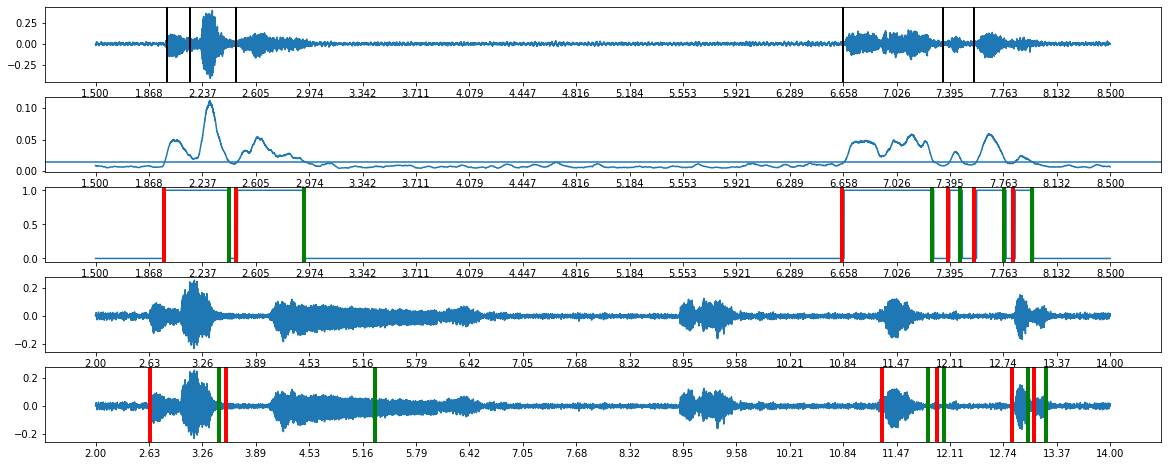

In [47]:
file1, seg1_1, seg1_2 = "report-pause1.wav", 1.5, 8.5
file2, seg2_1, seg2_2 = "report-combo2.wav", 2, 14

timelst1 = [1.99, 2.15, 2.47, 6.66, 7.35, 7.56]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.015,
      timelst1=timelst1, segments = segmentspause1, input_min_pause = 30)

# 27. pause2longword1 isinreport

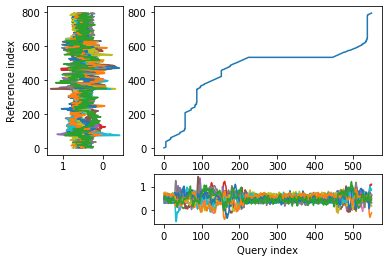

Stretch = 0.71
Distance  = 0.11
Correlation = 0.58


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.28947  1.74864    1.84846  2.57713  2.61706   3.0363  5.57169   
start 2  1.70871  3.32577    3.54537  5.60163  5.64156  6.11071  6.42015   
Adj R^2     0.43     0.16       0.46     0.29     0.65     0.19     0.46   
len 1       0.46     0.10       0.73     0.04     0.42     2.54     0.14   
len 2       1.62     0.22       2.06     0.04     0.47     0.31     0.14   
stretch     0.67     0.52       0.60     0.08     0.18     0.85     0.08   

               8        9  
seg        pause  project  
start 1  5.71143  5.80127  
start 2  6.55989  6.62976  
Adj R^2     0.46     0.70  
len 1       0.09     0.44  
len 2       0.07     0.43  
stretch     0.25     0.18

1      2          3      4      5      6     7      8        9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  project   
corr        0.43   0.16       0.46   0.29   0.65   0.19  0.46   0.46     0.70   
stretch     0.67   0.52       0.60   0.08   0.18   0.85  0.08   0.25     0.18   

           10  
seg       all  
corr     0.58  
stretch  0.71

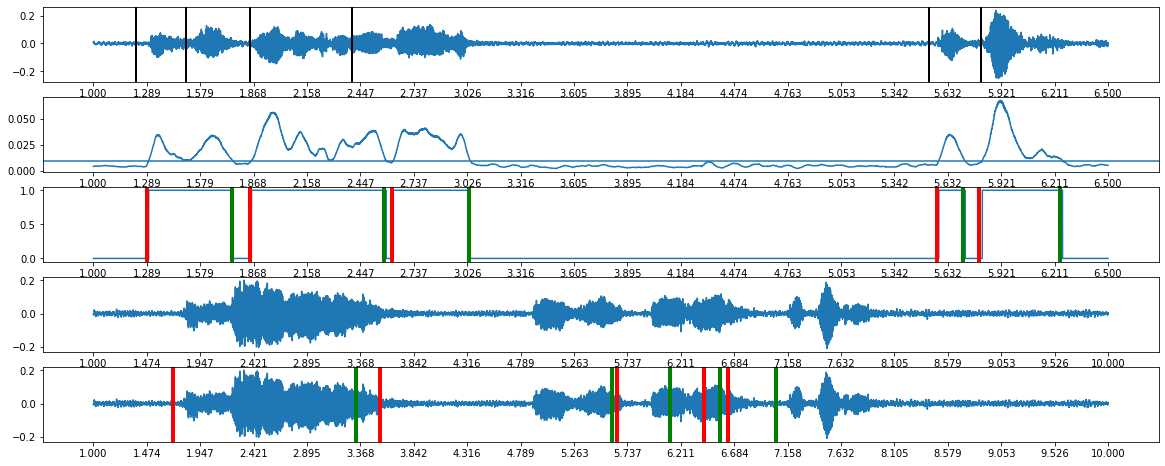

In [48]:
window_len = 50

file1, seg1_1, seg1_2 = "report-pause2.wav", 1, 6.5
file2, seg2_1, seg2_2 = "report-longword1.wav", 1, 10

timelst1 = [1.23, 1.5, 1.85, 2.40, 5.53, 5.81]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.01,
      timelst1=timelst1, segments = segments1, input_min_pause = 30)

# 28. pause2longword2

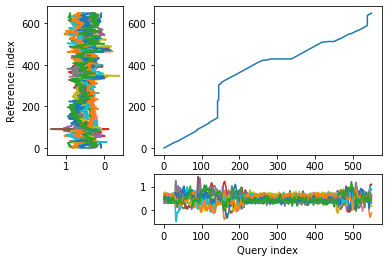

Stretch = 0.37
Distance  = 0.15
Correlation = 0.28


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.28947  1.74864    1.84846  2.57713  2.61706   3.0363  5.57169   
start 2  1.76951  2.20871    2.30853  4.71416  4.75408  5.16334  6.68058   
Adj R^2     0.52     0.29       0.26     0.11     0.25     0.04     0.33   
len 1       0.46     0.10       0.73     0.04     0.42     2.54     0.14   
len 2       0.44     0.10       2.41     0.04     0.41     1.52     0.12   
stretch     0.03     0.00       0.62     0.00     0.02     0.32     0.11   

               8        9  
seg        pause  project  
start 1  5.71143  5.80127  
start 2  6.80036   6.8902  
Adj R^2     0.12     0.54  
len 1       0.09     0.44  
len 2       0.09     0.36  
stretch     0.00     0.14

1      2          3      4      5      6     7      8        9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  project   
corr        0.52   0.29       0.26   0.11   0.25   0.04  0.33   0.12     0.54   
stretch     0.03   0.00       0.62   0.00   0.02   0.32  0.11   0.00     0.14   

           10  
seg       all  
corr     0.28  
stretch  0.37

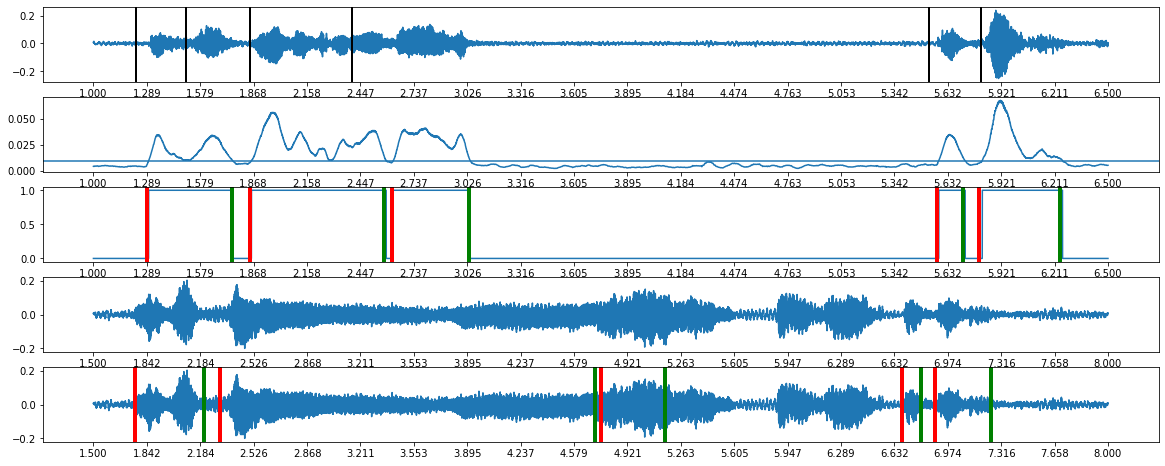

In [49]:
file1, seg1_1, seg1_2 = "report-pause2.wav", 1, 6.5
file2, seg2_1, seg2_2 = "report-longword2.wav", 1.5, 8

timelst1 = [1.23, 1.5, 1.85, 2.40, 5.53, 5.81]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.01,
      timelst1=timelst1, segments = segments1, input_min_pause = 30)

# 29. pause2combo1 isinreport

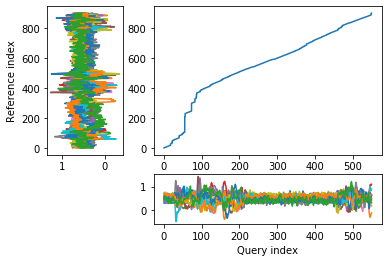

Stretch = 0.33
Distance  = 0.12
Correlation = 0.53


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.28947  1.74864    1.84846  2.57713  2.61706   3.0363  5.57169   
start 2  1.55898  3.99456    4.29401  5.61162  5.65154  6.11071  8.82577   
Adj R^2     0.41     0.18       0.50     0.15     0.76     0.18     0.41   
len 1       0.46     0.10       0.73     0.04     0.42     2.54     0.14   
len 2       2.44     0.30       1.32     0.04     0.46     2.72     0.27   
stretch     0.76     0.61       0.37     0.00     0.06     0.09     0.41   

               8        9  
seg        pause  project  
start 1  5.71143  5.80127  
start 2  9.09528  9.23503  
Adj R^2     0.34     0.66  
len 1       0.09     0.44  
len 2       0.14     0.41  
stretch     0.31     0.05

1      2          3      4      5      6     7      8        9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  project   
corr        0.41   0.18       0.50   0.15   0.76   0.18  0.41   0.34     0.66   
stretch     0.76   0.61       0.37   0.00   0.06   0.09  0.41   0.31     0.05   

           10  
seg       all  
corr     0.53  
stretch  0.33

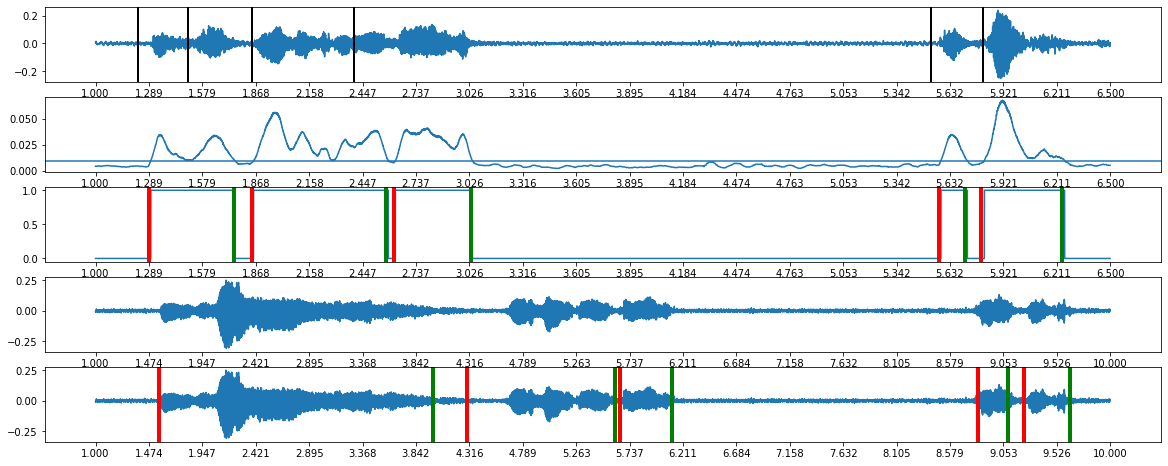

In [50]:
file1, seg1_1, seg1_2 = "report-pause2.wav", 1, 6.5
file2, seg2_1, seg2_2 = "report-combo1.wav", 1, 10

timelst1 = [1.23, 1.5, 1.85, 2.40, 5.53, 5.81]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.01,
      timelst1=timelst1, segments = segments1, input_min_pause = 30)

# 30. pause2combo2

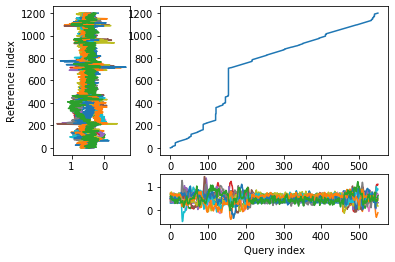

Stretch = 0.58
Distance  = 0.12
Correlation = 0.48


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.28947  1.74864    1.84846  2.57713  2.61706   3.0363  5.57169   
start 2  2.63884  3.43739     3.5971  9.11706  9.13702  9.55626  12.6007   
Adj R^2     0.52     0.31       0.51     0.24     0.67     0.08     0.02   
len 1       0.46     0.10       0.73     0.04     0.42     2.54     0.14   
len 2       0.80     0.16       5.52     0.02     0.42     3.04     0.14   
stretch     0.35     0.32       0.83     0.59     0.03     0.15     0.00   

               8        9  
seg        pause  project  
start 1  5.71143  5.80127  
start 2  12.7405  12.8303  
Adj R^2     0.10     0.68  
len 1       0.09     0.44  
len 2       0.09     0.41  
stretch     0.00     0.08

1      2          3      4      5      6     7      8        9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  project   
corr        0.52   0.31       0.51   0.24   0.67   0.08  0.02   0.10     0.68   
stretch     0.35   0.32       0.83   0.59   0.03   0.15  0.00   0.00     0.08   

           10  
seg       all  
corr     0.48  
stretch  0.58

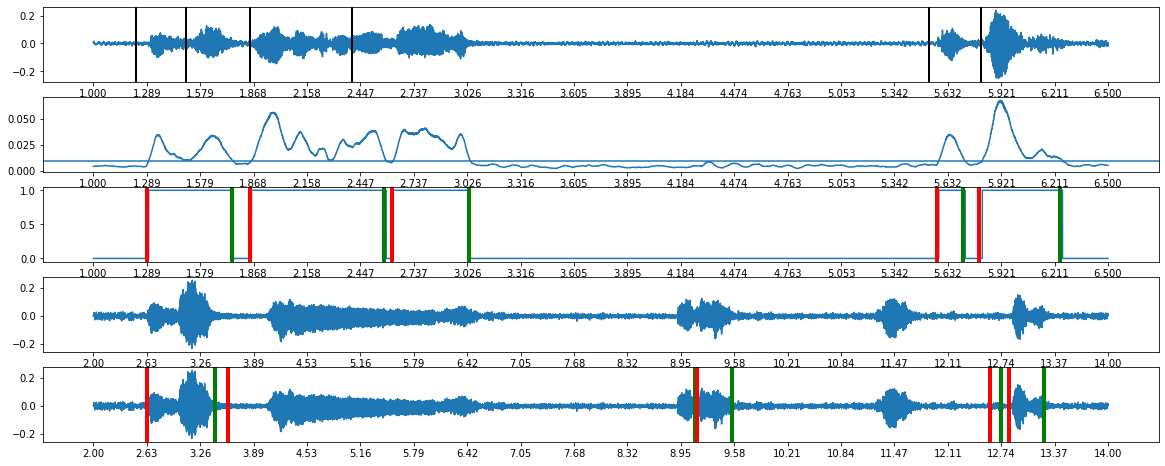

In [51]:
file1, seg1_1, seg1_2 = "report-pause2.wav", 1, 6.5
file2, seg2_1, seg2_2 = "report-combo2.wav", 2, 14

timelst1 = [1.23, 1.5, 1.85, 2.40, 5.53, 5.81]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.01,
      timelst1=timelst1, segments = segments1, input_min_pause = 30)

# 31. longword1longword2

In [52]:
segmentslongword1 = ['We have', 'pause', 'really enjoyed', 'pause', 'the', 'pause', 'pro', 'pause', 'ject', 'pause', '','', '','','', '']

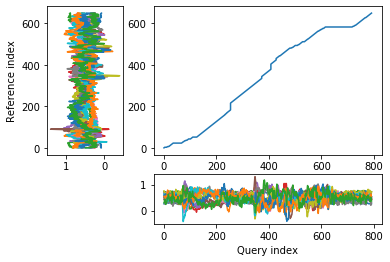

Stretch = 0.26
Distance  = 0.15
Correlation = 0.21


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1   1.7831  3.55359    4.88146  5.68726  5.91425   6.7314  7.13997   
start 2  1.78373  3.22509    4.95019  6.14187   6.4483  7.10656  7.36759   
Adj R^2     0.14     0.25       0.20     0.27     0.51     0.42     0.40   
len 1       1.77     1.33       0.81     0.23     0.82     0.41     0.17   
len 2       1.44     1.73       1.19     0.31     0.66     0.26     0.16   
stretch     0.20     0.24       0.31     0.27     0.20     0.35     0.12   

               8        9  
seg        pause  project  
start 1  7.31021  7.37831  
start 2  7.52648  7.59458  
Adj R^2     0.33     0.53  
len 1       0.07     0.48  
len 2       0.07     0.42  
stretch     0.08     0.16

1      2          3      4      5      6     7      8        9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  project   
corr        0.14   0.25       0.20   0.27   0.51   0.42  0.40   0.33     0.53   
stretch     0.20   0.24       0.31   0.27   0.20   0.35  0.12   0.08     0.16   

           10  
seg       all  
corr     0.21  
stretch  0.26

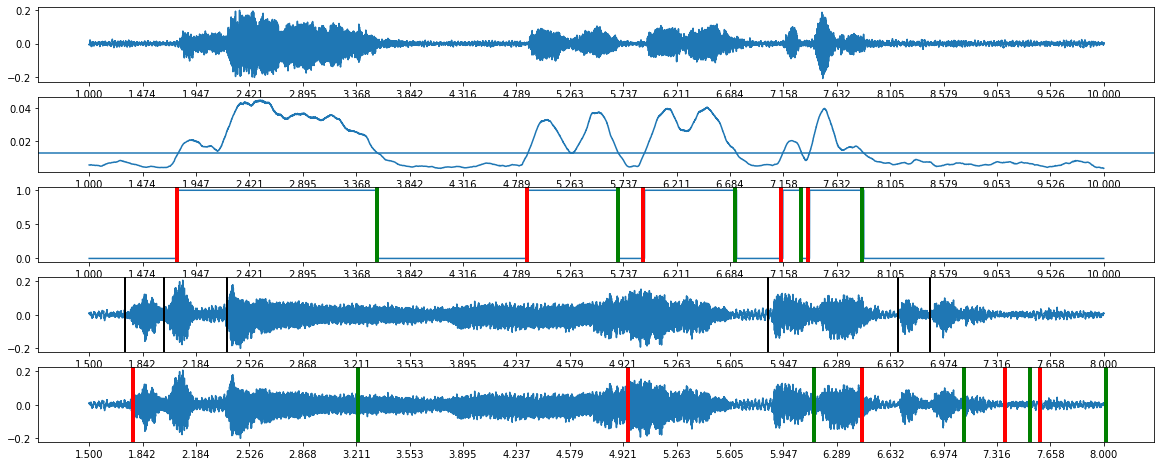

In [53]:
window_len = 150

file1, seg1_1, seg1_2 = "report-longword1.wav", 1, 10
file2, seg2_1, seg2_2 = "report-longword2.wav", 1.5, 8

timelst2 = [1.73, 1.98, 2.38, 5.85, 6.68, 6.89]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.013, timelst2=timelst2,
    segments = segments1)

# 32. longword1combo1 isinreport

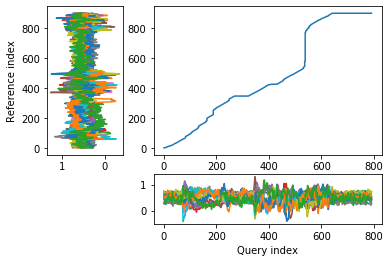

Stretch = 0.48
Distance  = 0.10
Correlation = 0.63


1        2          3        4        5       6        7  \
seg      We have    pause  really en    pause    joyed   pause      the   
start 1   1.7831  3.55359    4.88146  5.68726  5.91425  6.7314  7.13997   
start 2  1.62421    4.314     5.1425  5.82346  5.84615  6.7087  9.77301   
Adj R^2     0.60     0.34       0.52     0.09     0.46    0.37     0.55   
len 1       1.77     1.33       0.81     0.23     0.82    0.41     0.17   
len 2       2.69     0.83       0.68     0.02     0.86    3.06     0.48   
stretch     0.33     0.47       0.19     0.93     0.15    0.84     0.61   

               8        9  
seg        pause  project  
start 1  7.31021  7.37831  
start 2  10.2497  10.3291  
Adj R^2     0.40     0.71  
len 1       0.07     0.48  
len 2       0.08     0.49  
stretch     0.19     0.15

1      2          3      4      5      6     7      8        9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  project   
corr        0.60   0.34       0.52   0.09   0.46   0.37  0.55   0.40     0.71   
stretch     0.33   0.47       0.19   0.93   0.15   0.84  0.61   0.19     0.15   

           10  
seg       all  
corr     0.63  
stretch  0.48

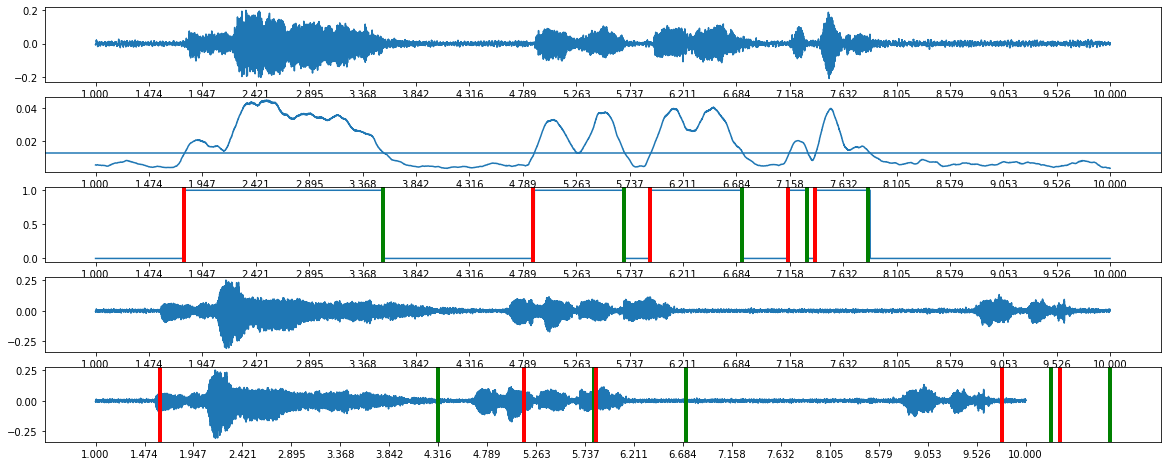

In [54]:
file1, seg1_1, seg1_2 = "report-longword1.wav", 1, 10
file2, seg2_1, seg2_2 = "report-combo1.wav", 1, 10

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.013, segments = segments1)

# 33. longword1combo2

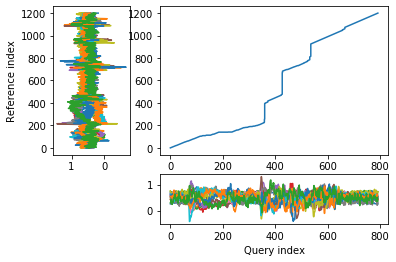

Stretch = 0.65
Distance  = 0.12
Correlation = 0.59


1        2          3        4        5       6        7  \
seg      We have    pause  really en    pause    joyed   pause      the   
start 1   1.7831  3.55359    4.88146  5.68726  5.91425  6.7314  7.13997   
start 2  2.70366  3.60025    4.36066  7.19798  9.80832  10.512  12.5549   
Adj R^2     0.54     0.30       0.37     0.15     0.52    0.46     0.40   
len 1       1.77     1.33       0.81     0.23     0.82    0.41     0.17   
len 2       0.90     0.76       2.84     2.61     0.70    2.04     0.17   
stretch     0.45     0.40       0.68     0.90     0.19    0.76     0.07   

               8        9  
seg        pause  project  
start 1  7.31021  7.37831  
start 2  12.7251  12.7932  
Adj R^2     0.09     0.20  
len 1       0.07     0.48  
len 2       0.07     0.48  
stretch     0.07     0.07

1      2          3      4      5      6     7      8        9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  project   
corr        0.54   0.30       0.37   0.15   0.52   0.46  0.40   0.09     0.20   
stretch     0.45   0.40       0.68   0.90   0.19   0.76  0.07   0.07     0.07   

           10  
seg       all  
corr     0.59  
stretch  0.65

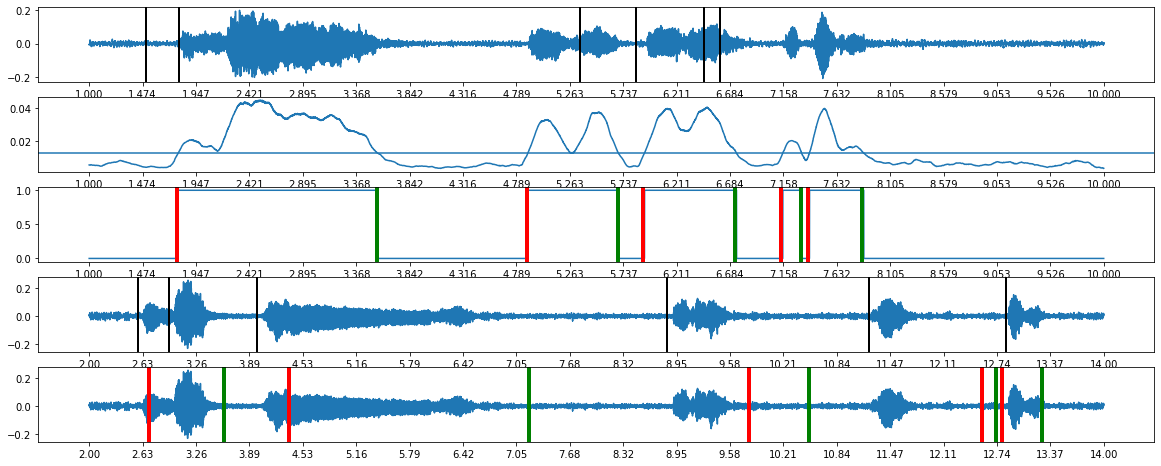

In [55]:
file1, seg1_1, seg1_2 = "report-longword1.wav", 1, 10
file2, seg2_1, seg2_2 = "report-combo2.wav", 2, 14

timelst1 = [1.5, 1.80, 5.35, 5.85, 6.45, 6.6]
timelst2 = [2.58, 2.95, 3.98, 8.84, 11.22, 12.85]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.013, timelst2=timelst2,
      timelst1=timelst1, segments = segments1)

# 34. longword2combo1

In [56]:
segmentslongword2 = ['We have', 'pause', 'rea', 'pause', 'lly', 'pause', 'enjoyed', 'pause',  'the', 'pause', 'project', 'pause', 'ject', 'pause', '','', '']

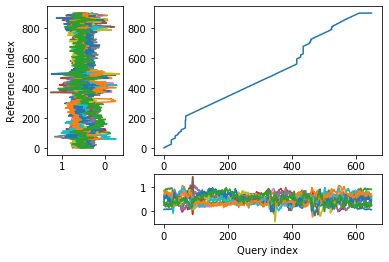

Stretch = 0.25
Distance  = 0.16
Correlation = 0.16


1        2        3        4        5        6        7   \
seg      We have    pause      rea    pause      lly    pause  enjoyed   
start 1  1.74962  2.17896  2.24885    3.447  3.79647  5.50384  5.82335   
start 2  1.54916  2.84716  3.18664  4.38479  4.73425  6.44163   7.2404   
Adj R^2     0.50     0.06     0.06     0.13     0.07     0.02     0.02   
len 1       0.43     0.07     1.20     0.35     1.71     0.32     0.68   
len 2       1.30     0.34     1.20     0.35     1.71     0.80     1.41   
stretch     0.59     0.76     0.00     0.00     0.01     0.52     0.44   

              8        9        10       11  
seg        pause      the    pause  project  
start 1   6.5023  6.67204  6.80184  6.89171  
start 2  8.64823  8.81797  9.14747  9.23733  
Adj R^2     0.17     0.33     0.12     0.36  
len 1       0.17     0.13     0.09     0.16  
len 2       0.17     0.33     0.09     0.19  
stretch     0.00     0.54     0.00     0.12

1      2     3      4     5      6        7      8     9   \
seg      We have  pause   rea  pause   lly  pause  enjoyed  pause   the   
corr        0.50   0.06  0.06   0.13  0.07   0.02     0.02   0.17  0.33   
stretch     0.59   0.76  0.00   0.00  0.01   0.52     0.44   0.00  0.54   

            10       11    12  
seg      pause  project   all  
corr      0.12     0.36  0.16  
stretch   0.00     0.12  0.25

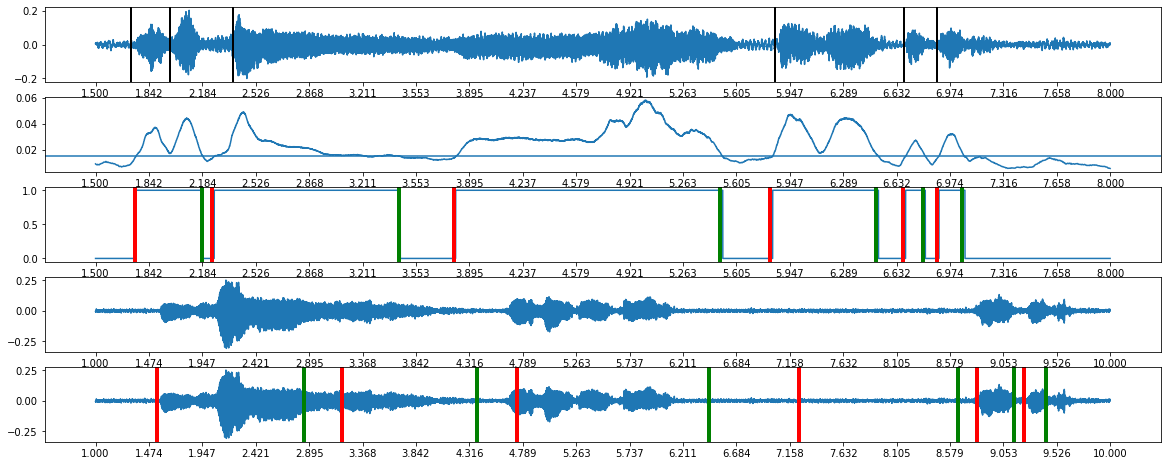

In [57]:
window_len = 100

file1, seg1_1, seg1_2 = "report-longword2.wav", 1.5, 8
file2, seg2_1, seg2_2 = "report-combo1.wav", 1, 10

timelst1 = [1.73, 1.98, 2.38, 5.85, 6.68, 6.89]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.015,
      timelst1=timelst1, segments = segmentslongword2)

# 35. longword2combo2

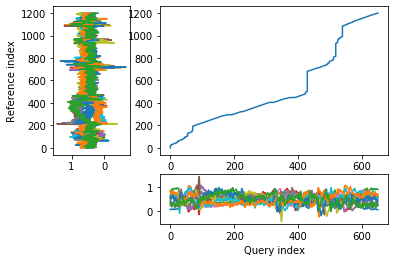

Stretch = 0.48
Distance  = 0.13
Correlation = 0.55


1        2        3        4        5        6        7   \
seg      We have    pause      rea    pause      lly    pause  enjoyed   
start 1  1.74962  2.17896  2.24885    3.447  3.79647  5.50384  5.82335   
start 2  2.57911   3.4278  3.97696  4.96544  5.25499  6.57296  8.83948   
Adj R^2     0.60     0.29     0.65     0.15     0.23     0.20     0.56   
len 1       0.43     0.07     1.20     0.35     1.71     0.32     0.68   
len 2       0.85     0.55     0.99     0.29     1.32     2.27     0.88   
stretch     0.41     0.85     0.13     0.13     0.17     0.82     0.22   

              8        9        10       11  
seg        pause      the    pause  project  
start 1   6.5023  6.67204  6.80184  6.89171  
start 2  9.71813  10.1375  11.7151  12.8134  
Adj R^2     0.13     0.51     0.12     0.43  
len 1       0.17     0.13     0.09     0.16  
len 2       0.42     1.58     1.10     0.21  
stretch     0.53     0.90     0.90     0.19

1      2     3      4     5      6        7      8     9   \
seg      We have  pause   rea  pause   lly  pause  enjoyed  pause   the   
corr        0.60   0.29  0.65   0.15  0.23   0.20     0.56   0.13  0.51   
stretch     0.41   0.85  0.13   0.13  0.17   0.82     0.22   0.53  0.90   

            10       11    12  
seg      pause  project   all  
corr      0.12     0.43  0.55  
stretch   0.90     0.19  0.48

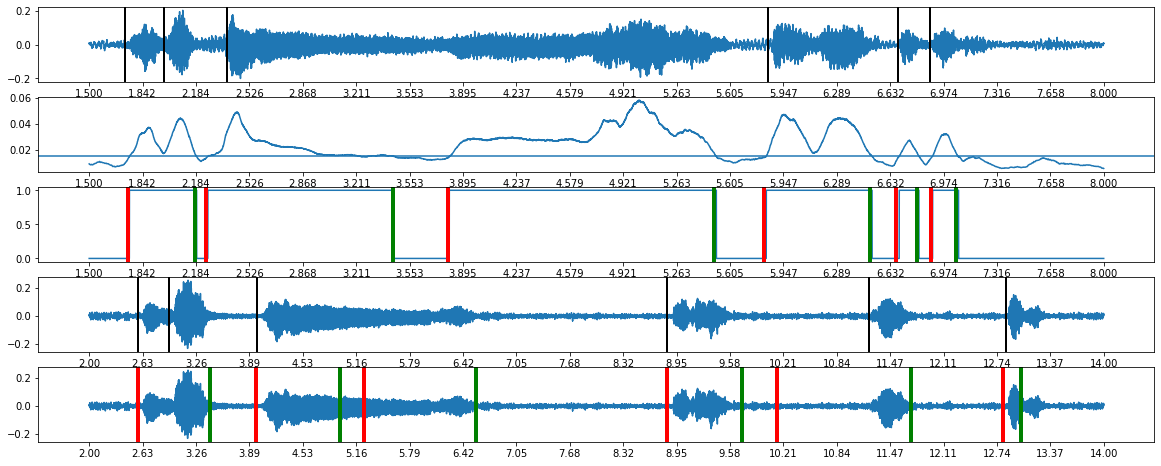

In [58]:
file1, seg1_1, seg1_2 = "report-longword2.wav", 1.5, 8
file2, seg2_1, seg2_2 = "report-combo2.wav", 2, 14

timelst1 = [1.73, 1.98, 2.38, 5.85, 6.68, 6.89]
timelst2 = [2.58, 2.95, 3.98, 8.84, 11.22, 12.85]

output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.015, timelst2=timelst2,
      timelst1=timelst1, segments = segmentslongword2)

# 36. combo1combo2

In [59]:
segmentscombo1 = ['We', 'pause', 'have', 'pause', 'really', 'pause', 'en', 'pause', 'joyed', 'pause', 'project', 'pause', 'pro', 'pause', 'ject', 'pause', '','', '']

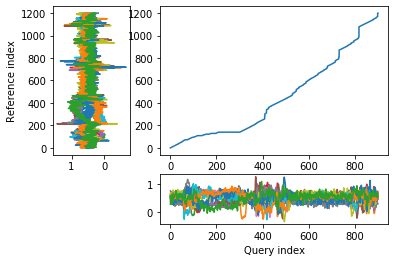

Stretch = 0.36
Distance  = 0.13
Correlation = 0.46


1        2          3        4        5        6        7  \
seg      We have    pause  really en    pause    joyed    pause      the   
start 1  1.54939  3.91676    4.63596  5.58491  5.63485  6.08435  8.78135   
start 2  2.60932  3.39845    4.04772  5.94562  5.99556  6.47503  11.2098   
Adj R^2     0.58     0.22       0.23     0.23     0.28     0.04     0.47   
len 1       2.37     0.72       0.95     0.05     0.45     2.70     0.37   
len 2       0.79     0.65       1.90     0.05     0.48     4.73     0.54   
stretch     0.60     0.11       0.42     0.00     0.05     0.35     0.25   

               8        9  
seg        pause  project  
start 1  9.15094  9.23085  
start 2  11.7492   12.828  
Adj R^2     0.14     0.57  
len 1       0.08     0.37  
len 2       1.08     0.37  
stretch     0.91     0.04

1      2          3      4      5      6     7      8        9   \
seg      We have  pause  really en  pause  joyed  pause   the  pause  project   
corr        0.58   0.22       0.23   0.23   0.28   0.04  0.47   0.14     0.57   
stretch     0.60   0.11       0.42   0.00   0.05   0.35  0.25   0.91     0.04   

           10  
seg       all  
corr     0.46  
stretch  0.36

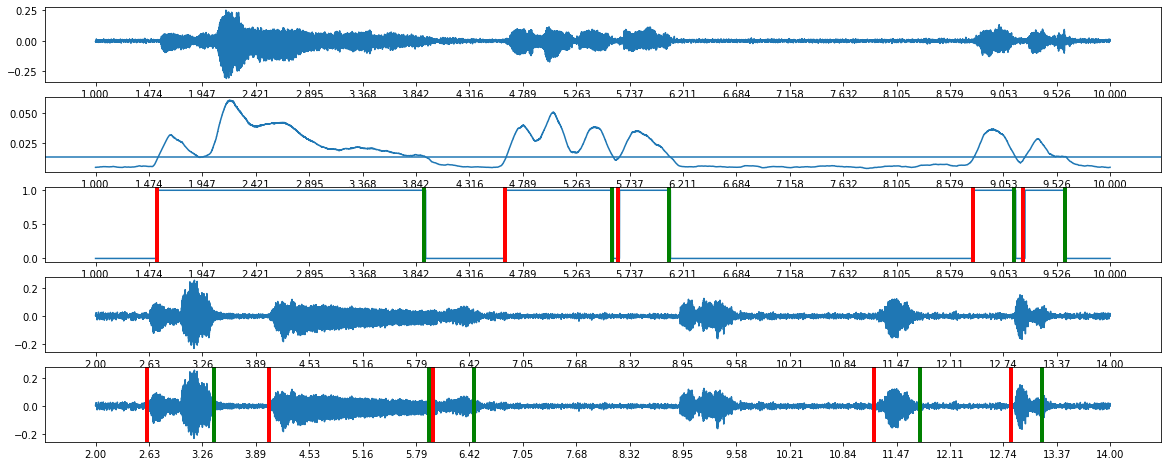

In [60]:
window_len = 150

file1, seg1_1, seg1_2 = "report-combo1.wav", 1, 10
file2, seg2_1, seg2_2 = "report-combo2.wav", 2, 14


output(file1, seg1_1, seg1_2, file2, seg2_1, seg2_2, threshold1 = 0.013, segments = segments1, input_min_pause = 30)